# TODO
Understand if there is a seasonality component

# Analyze Data 

In [948]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import json 
from sklearn.cluster import KMeans, SpectralClustering
from collections import Counter
from skimage.color import rgb2lab
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
import hdbscan
import statsmodels.api as sm
import ast


## Load Data

In [791]:
df_image = pd.read_csv('../data_clean/df_image2.csv').drop(columns=['ref_id', 'img_name' ])
df_target = pd.read_csv('../data_clean/df_target.csv')
df_text = pd.read_csv('../data_clean/df_text.csv') 
df_reach = pd.read_csv('../data_clean/df_reach.csv')
df_active = pd.read_csv('../data_clean/all_brands.csv')

X_train = pd.read_csv('../data_clean/X_train.csv')
X_test = pd.read_csv('../data_clean/X_test.csv')
y_train= pd.read_csv('../data_clean/y_train.csv')
y_test= pd.read_csv('../data_clean/y_test.csv')

map_page_name , map_page_name_num = json.load(open('../data_clean/page_name_map.json'))

In [792]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   2915 non-null   int64  
 1   ad_delivery_start_year               2915 non-null   int64  
 2   ad_delivery_start_month              2915 non-null   int64  
 3   eu_total_reach                       2915 non-null   int64  
 4   publisher_platform_facebook          2915 non-null   int64  
 5   publisher_platform_instagram         2915 non-null   int64  
 6   publisher_platform_audience_network  2915 non-null   int64  
 7   publisher_platform_messenger         2915 non-null   int64  
 8   target_ages_lower                    2915 non-null   int64  
 9   target_ages_upper                    2915 non-null   int64  
 10  target_gender_men                    2915 non-null   int64  
 11  target_gender_women           

In [793]:
topic_cols = [col for col in X_train.columns if 'topic_' in col] 
publisher_cols = [col for col in X_train.columns if 'publisher_' in col]
language_cols = [col for col in X_train.columns if 'language_' in col]
color_cols = ['r1', 'r2', 'r3', 'g1', 'g2', 'g3', 'b1', 'b2', 'b3']
img_cols = ['has_person', 'background_entropy']
target_cols = [col for col in X_train.columns if 'target_' in col]
delivery_timing_cols =['ad_delivery_start_year', 'ad_delivery_start_month']

topic_cols, publisher_cols, language_cols, color_cols, target_cols, delivery_timing_cols

(['topic_latest_armario', 'topic_maison_collection'],
 ['publisher_platform_facebook',
  'publisher_platform_instagram',
  'publisher_platform_audience_network',
  'publisher_platform_messenger'],
 ['language_de', 'language_en', 'language_es', 'language_fr', 'language_it'],
 ['r1', 'r2', 'r3', 'g1', 'g2', 'g3', 'b1', 'b2', 'b3'],
 ['target_ages_lower',
  'target_ages_upper',
  'target_gender_men',
  'target_gender_women'],
 ['ad_delivery_start_year', 'ad_delivery_start_month'])

## 1. What elements of ads does a company use to portray its brand?

### Take 1: Include all content calls 

In [885]:
sc = StandardScaler()
content_cols = color_cols +  publisher_cols + language_cols + img_cols + topic_cols 

X_train_trans = sc.fit_transform(X_train[content_cols])
X_test_trans = sc.fit_transform(X_test[content_cols])

In [886]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_trans, y_train)
y_pred = rf.predict(X_train_trans)
print('train accuracy', accuracy_score(y_train, y_pred))
y_pred = rf.predict(X_test_trans)
print('test accuracy', accuracy_score(y_test, y_pred))

c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train accuracy 1.0
test accuracy 0.6872427983539094


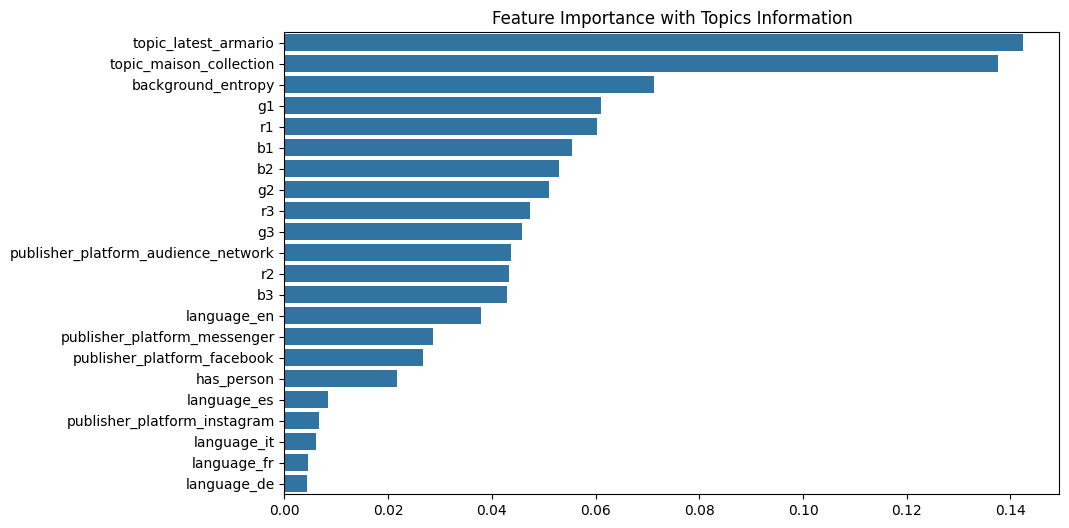

In [867]:
# plot feature importances
importances = rf.feature_importances_  
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance with Topics Information")

sns.barplot(x=importances[indices], y=range(X_train_trans.shape[1]), orient='h')
plt.yticks(range(X_train_trans.shape[1]), np.asarray(content_cols)[indices])
plt.show()

#### Topic

In [868]:
y_train_text = X_train[['id']].merge(df_active[['id', 'page_name']], on='id')['page_name']

Text(0.5, 1.0, 'Fashion Ads in Topic Space')

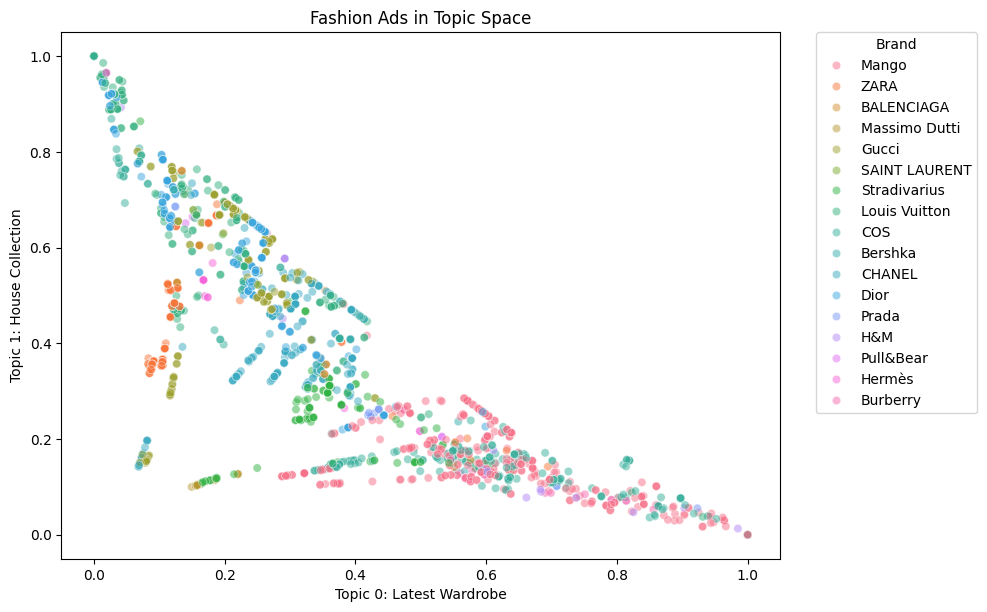

In [869]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = X_train, 
                x = topic_cols[0], 
                y = topic_cols[1],
                hue =  y_train_text,
                alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title="Brand")
plt.tight_layout()
plt.xlabel("Topic 0: Latest Wardrobe")
plt.ylabel("Topic 1: House Collection")
plt.title('Fashion Ads in Topic Space')

In [870]:
y_train_brand_type = X_train[['id']].merge(df_active[['id', 'brand_type']], on='id')['brand_type'].str.title()

Text(0.5, 1.0, 'Fashion Ads in Topic Space')

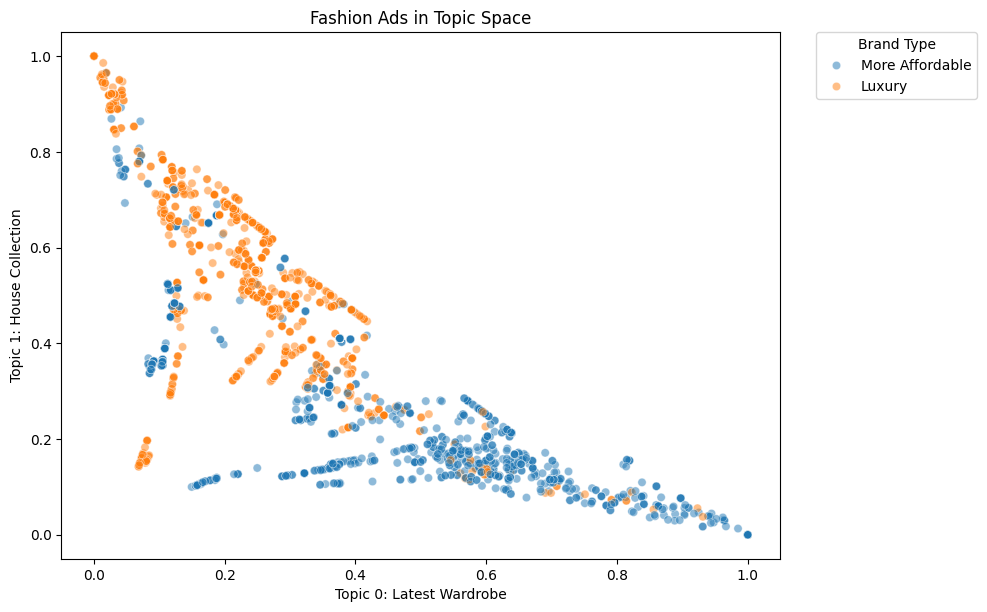

In [871]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = X_train, 
                x = topic_cols[0], 
                y = topic_cols[1],
                hue =  y_train_brand_type,
                alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title="Brand Type")
plt.tight_layout()
plt.xlabel("Topic 0: Latest Wardrobe")
plt.ylabel("Topic 1: House Collection")
plt.title('Fashion Ads in Topic Space')

In [859]:
tmp_armario_txt = X_train.loc[(X_train.topic_latest_armario>0.8) & (X_train.language_en==1), ['id']].merge(df_active[['id','ad_creative_bodies', 'page_name']], on='id').head(20)

tmp_armario_txt["ad_creative_bodies"] = tmp_armario_txt["ad_creative_bodies"].fillna("[]").apply(ast.literal_eval)
tmp_armario_txt = tmp_armario_txt.drop_duplicates(subset=["ad_creative_bodies"])

for ind, row in tmp_armario_txt.iterrows():
    print('Brand Name:', row["page_name"])
    print('Description:' ,row["ad_creative_bodies"][0])

Brand Name: COS
Description: The relaxed suit in fine windowpane-check wool – honouring the codes of classic tailoring.
Brand Name: COS
Description: Refined pieces in a purist palette for now and later.
Brand Name: COS
Description: Signature dresses and fluid tailoring in lighter fabrics propose an easy refinement for the season's more formal occasions.
Brand Name: COS
Description: Signature silhouettes, airy volumes and artful touches – the new dresses of the season embody a refined yet relaxed sensibility.
Brand Name: COS
Description: Striking silhouettes for special occasions, combining sophistication with the ease of summer.
Brand Name: Mango
Description: New season, renewed style. 🤎 
The temperatures are falling and your wardrobe is renewing itself with more style than ever before with the soft and warm garments you missed so much. 🍂
Brand Name: Louis Vuitton
Description: Explore the versatile, colored textile edition of the Neverfull Inside Out bag showcased by House Ambassador S

In [839]:
tmp_maison_txt = X_train.loc[(X_train.topic_maison_collection>0.8) & (X_train.language_en==1), ['id']].merge(df_active[['id','ad_creative_bodies', 'page_name']], on='id').head(20)

tmp_maison_txt["ad_creative_bodies"] = tmp_maison_txt["ad_creative_bodies"].fillna("[]").apply(ast.literal_eval)
tmp_maison_txt = tmp_maison_txt.drop_duplicates(subset=["ad_creative_bodies"])

for ind, row in tmp_maison_txt.iterrows():
    try:
        print('Brand Name:', row["page_name"])
        print('Description:' ,row["ad_creative_bodies"][0])
    except:
        pass

Brand Name: H&M
Description: The Pre-loved Archive looks good on you, @jxrdan.
Brand Name: Dior
Description: Discover the Dior Spring-Summer 2025 collection by Maria Grazia Chiuri, a wardrobe pushing the boundaries of contemporary femininity.
Brand Name: Louis Vuitton
Description: Men's Spring-Summer 2025. A chromatic play of the House's signature emblems, Pharrell Williams introduces a voyage-ready collection.
Brand Name: Stradivarius
Description: Dive into our AW24 style guide and get a preview of what comes next.
Brand Name: COS
Description: Meet the icons of Autumn Winter 2024 – the new champions of artistry and craft.
Brand Name: Prada
Description: Relive the highlights of the #PradaFW25 Womenswear fashion show designed by Miuccia Prada and Raf Simons.
Brand Name: Prada
Description: Finite sequences of instructions circumscribe the decidable through logic in a fundamentally illogical world.
Discover more via link in bio.

#PradaSS25
#MiucciaPrada
#RafSimons
Brand Name: Dior


### Take 2: Exclude Topics

In [892]:
sc = StandardScaler()
content_cols = color_cols +  publisher_cols + language_cols + img_cols   

X_train_trans = sc.fit_transform(X_train[content_cols])
X_test_trans = sc.fit_transform(X_test[content_cols])

In [893]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_trans, y_train)
y_pred = rf.predict(X_train_trans)
print('train accuracy', accuracy_score(y_train, y_pred))
y_pred = rf.predict(X_test_trans)
print('test accuracy', accuracy_score(y_test, y_pred))

c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train accuracy 1.0
test accuracy 0.9519890260631001


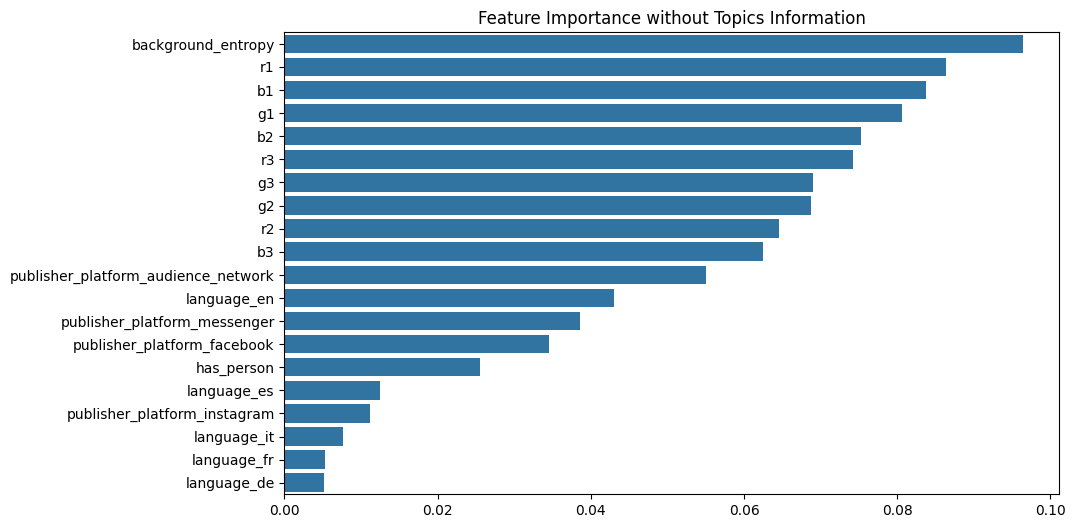

In [894]:
# plot feature importances
importances = rf.feature_importances_  
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance without Topics Information")

sns.barplot(x=importances[indices], y=range(X_train_trans.shape[1]), orient='h')
plt.yticks(range(X_train_trans.shape[1]), np.asarray(content_cols)[indices])
plt.show()

#### Background Entropy

Text(0.5, 1.0, 'Distribution of Background Entropy')

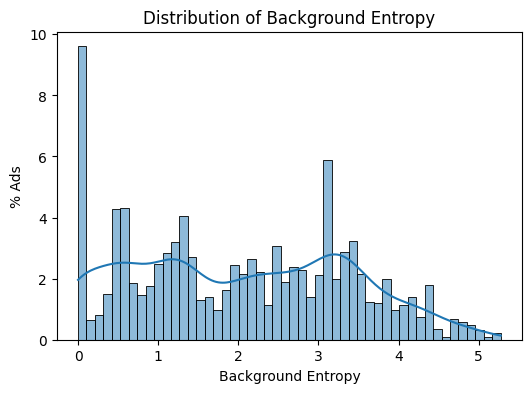

In [876]:
plt.figure(figsize=(6, 4))
sns.histplot(X_train.background_entropy, kde=True, bins=50,  stat='percent')
plt.xlabel('Background Entropy')
plt.ylabel('% Ads')
plt.title('Distribution of Background Entropy')

In [161]:
df_brand_img = pd.read_csv('../data_clean/df_image.csv')[[ 'page_name', 'ref_id']].drop_duplicates()
df_brand_img = df_brand_img.merge(X_train[['id', 'background_entropy']], 
                                  left_on='ref_id', 
                                  right_on='id', 
                                  how='left')

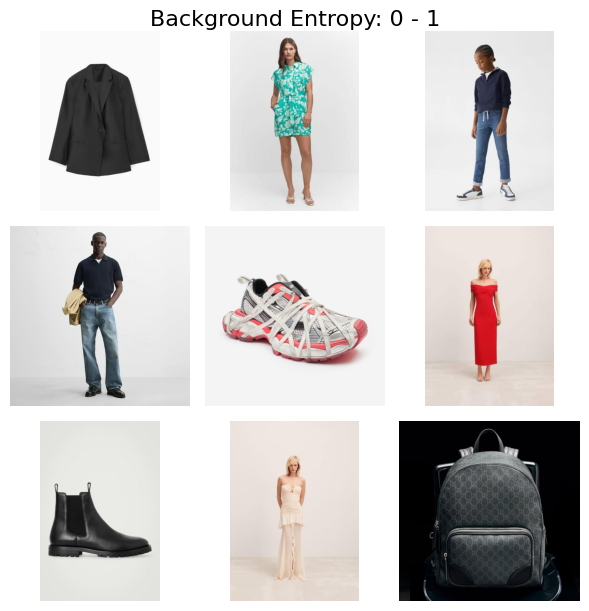

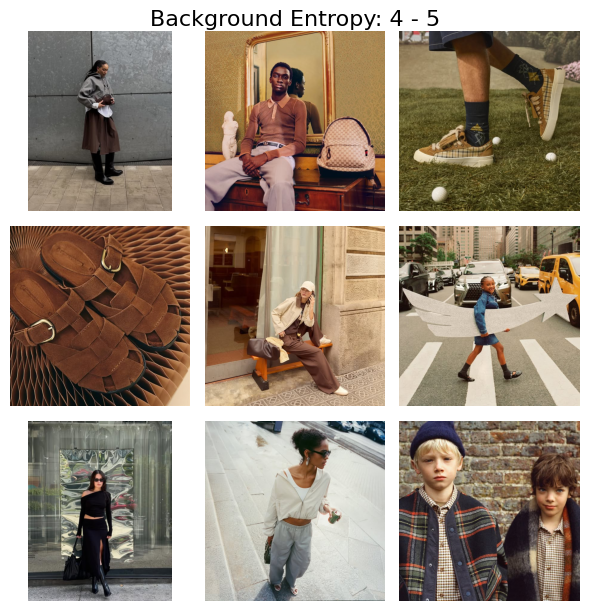

In [377]:
l,u = 0,1

def plot_entropy(l, u):
    figure, ax = plt.subplots(3,3, figsize=(6, 6))
    plot_df = df_brand_img[df_brand_img['background_entropy'].between(l, u)].sample(9).reset_index(drop=True)

    for i, row in plot_df.iterrows():
        image_path = f'../data_clean/unique_imgs2/{row["ref_id"]}.png'
        img = Image.open(image_path)
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')

    plt.tight_layout()
    plt.suptitle( f"Background Entropy: {l} - {u}", fontsize=16, y=1.01)
    plt.show()

plot_entropy(0, 1)
plot_entropy(4, 5)

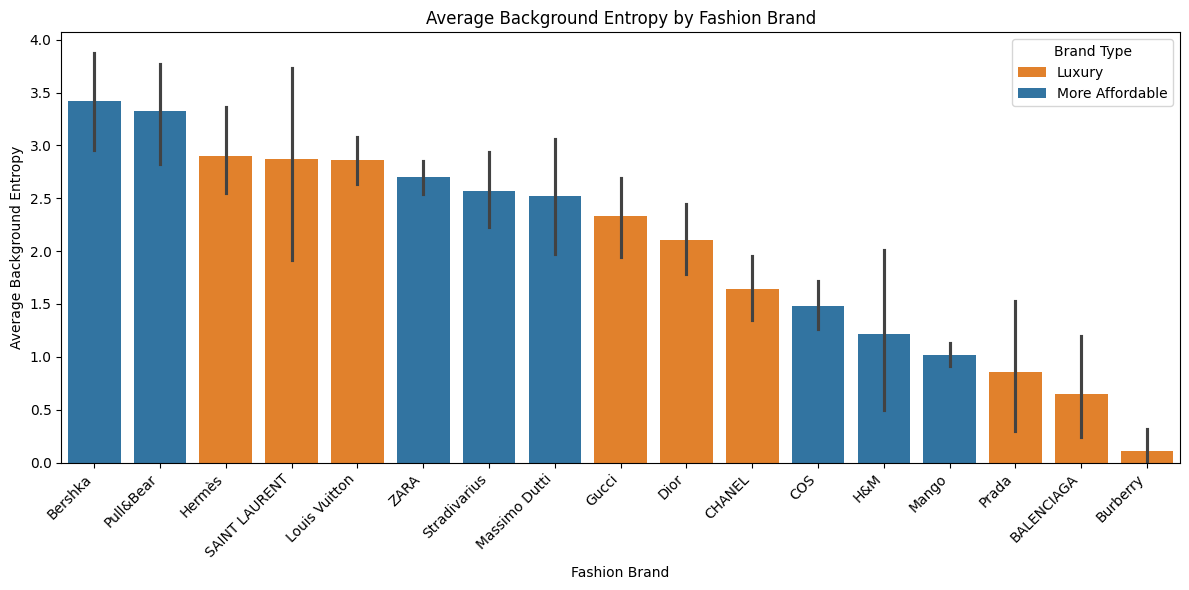

In [380]:
plt.figure(figsize=(12, 6))
tmp = df_brand_img.merge(df_active[['id', 'brand_type']], on = 'id')
tmp['brand_type'] = tmp['brand_type'].str.title()

sns.barplot(data=tmp, 
            x='page_name', 
            y='background_entropy', 
            estimator=np.mean, 
            hue = 'brand_type',
            order=tmp.groupby('page_name')['background_entropy'].mean().sort_values(ascending=False).index,
            palette=sns.color_palette()[:2][::-1]
           )
plt.legend(title='Brand Type', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Fashion Brand')
plt.ylabel('Average Background Entropy')
plt.title('Average Background Entropy by Fashion Brand')
plt.tight_layout()
plt.show()

In [877]:
def sample_brand_image(brand):
    figure, ax = plt.subplots(3,3, figsize=(6, 6))
    plot_df = df_brand_img[df_brand_img['page_name'] == brand].sample(9).reset_index(drop=True)

    for i, row in plot_df.iterrows():
        image_path = f'../data_clean/unique_imgs2/{row["ref_id"]}.png'
        img = Image.open(image_path)
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')

    plt.tight_layout()
    plt.suptitle(brand, fontsize=16, y=1.01)
    plt.show()

    plot_df2 = plot_df.merge(df_image, left_on='ref_id', right_on='id', how='left')
    figure, ax = plt.subplots(3, 3 * 3, figsize=(9, 3.5))  # Adjusted figure size for better visibility

    for ind, row in plot_df2.iterrows():
        j = ind % 3 * 3
        i = ind // 3

        for c in [1, 2, 3]:
            color = row[[f'r{c}', f'g{c}', f'b{c}']].values.astype(int)
            color = color.reshape(1, 1, 3)
            ax[i, j + c - 1].imshow(color)
            ax[i, j + c - 1].axis('off')

    plt.tight_layout()
    plt.suptitle(f'Color Palette for {brand}', fontsize=16, y=1.01)
    plt.show()

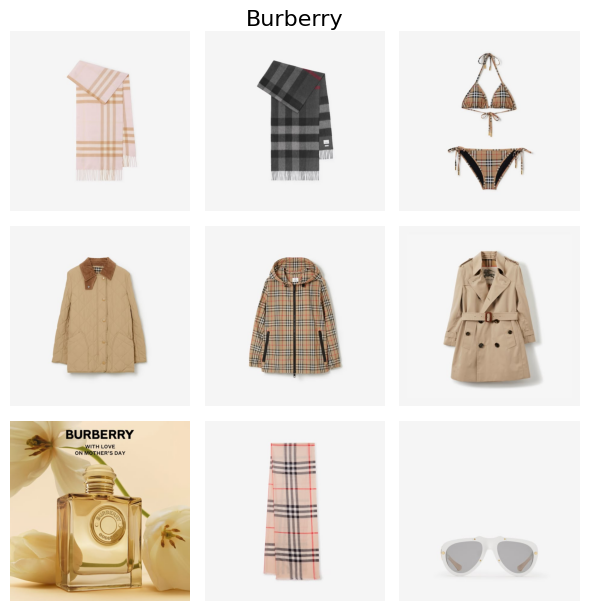

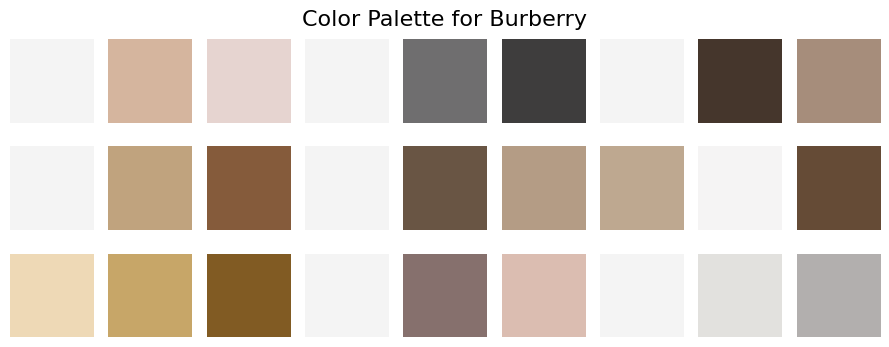

In [880]:
sample_brand_image('Burberry')

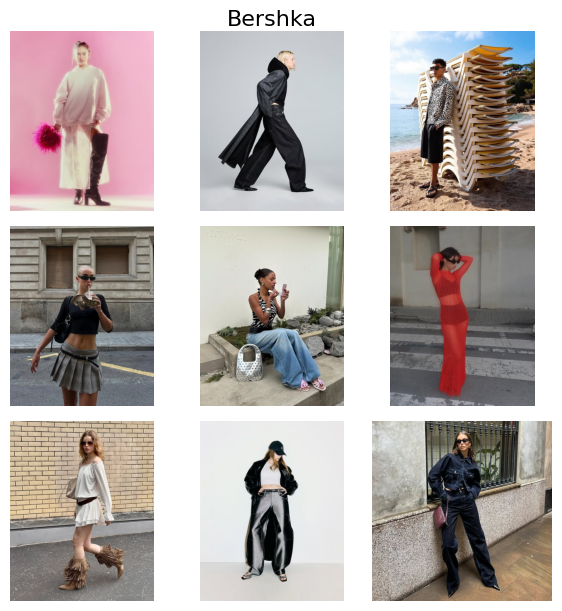

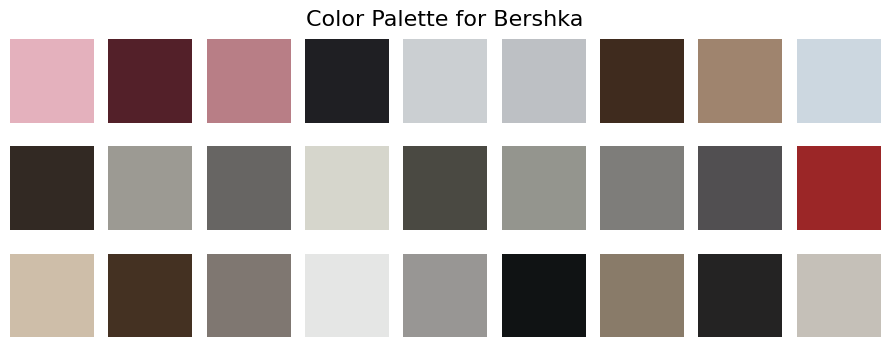

In [884]:
sample_brand_image('Bershka')

#### Brand Colors

In [151]:
df_color = df_image.merge(df_active[['id', 'page_name']], on='id', how='left')[['page_name', 'id'] + color_cols]
df_color2 = pd.concat([
    df_color[['page_name', 'id', 'r1', 'g1', 'b1']].rename(columns={'r1': 'r', 'g1': 'g', 'b1': 'b'}),
    df_color[['page_name', 'id', 'r2', 'g2', 'b2']].rename(columns={'r2': 'r', 'g2': 'g', 'b2': 'b'}),
    df_color[['page_name', 'id', 'r3', 'g3', 'b3']].rename(columns={'r3': 'r', 'g3': 'g', 'b3': 'b'})
])
df_color2.head()

page_name                id      r      g      b
0    CHANEL   659995843340699  247.0  229.0  247.0
1    CHANEL   512395855279095  247.0  229.0  247.0
2    CHANEL   673107428584991  246.0  245.0  243.0
3    CHANEL  9438819812832957  246.0  245.0  243.0
4    CHANEL   496074753439720  214.0  204.0  204.0

In [ ]:
brand = 'Dior'
tmp_colors = df_color2.loc[df_color2['page_name'] == brand, ['r', 'g', 'b']].values


In [249]:
def get_brand_colors(array,  n_clusters=5):
    arr = array.copy()
    model = hdbscan.HDBSCAN(min_cluster_size = round(arr.shape[0] * 0.05))
    labels = model.fit_predict(arr)
    counts = Counter(labels)
    sorted_colors = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    topic_cols = [ label for label, count in sorted_colors if label != -1 ][:n_clusters]
    colors = np.array([arr[labels == label].mean(axis=0) for label in topic_cols])
    return colors

df_brand_color = pd.DataFrame(columns=['page_name'] )
df_brand_color['page_name'] = df_color2.page_name.unique()

for page_name in df_color2['page_name'].unique():
    d = df_color2.loc[df_color2.page_name == page_name, ['r', 'g', 'b']].dropna().values
    top_colors = get_brand_colors(d)

    for i, color in enumerate(top_colors):
        r, g, b = color
        df_brand_color.loc[df_brand_color['page_name'] == page_name, f'r{i+1}'] = r
        df_brand_color.loc[df_brand_color['page_name'] == page_name, f'g{i+1}'] = g
        df_brand_color.loc[df_brand_color['page_name'] == page_name, f'b{i+1}'] = b    

new_color_cols = df_brand_color.columns[1:]
df_brand_color[new_color_cols] = df_brand_color[new_color_cols]/255


c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

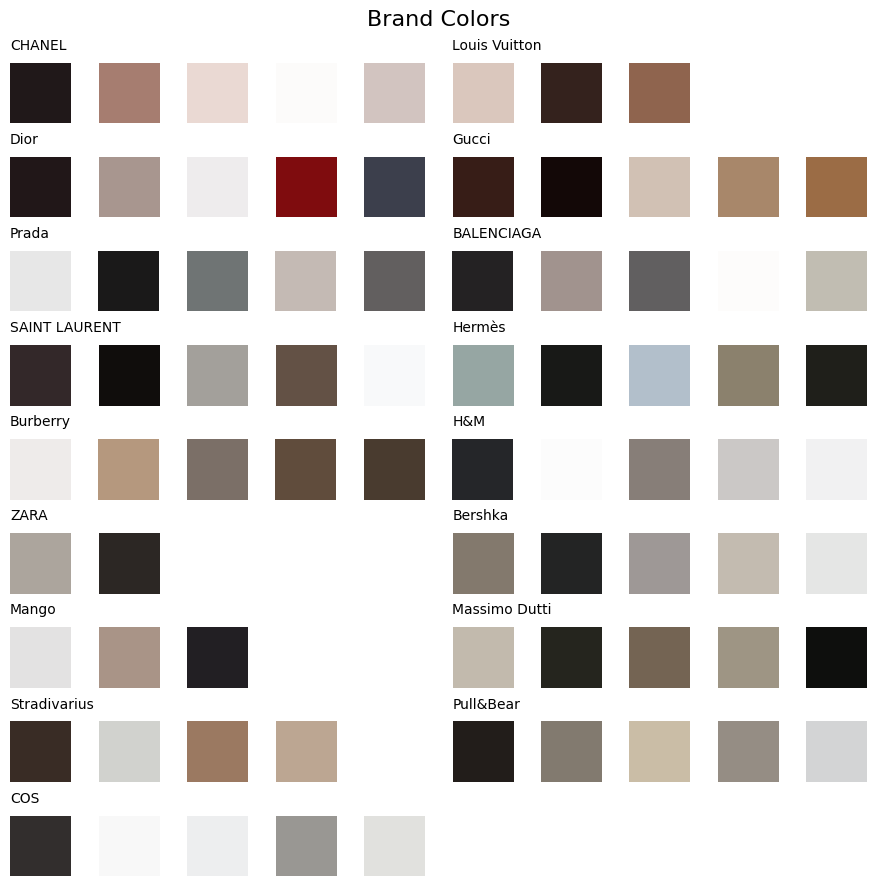

In [252]:
num_brands = df_brand_color.page_name.nunique()
figure, ax = plt.subplots(num_brands//2+1, 10, figsize=(9, 9))

for ind, row in df_brand_color.iterrows():
    brand = row['page_name']
    i = ind//2
    j = ind%2 *5
    for c in [1,2,3,4,5]:
        color = row[[f'r{c}', f'g{c}', f'b{c}']].values.astype(float)
        color = color.reshape(1, 1, 3)  
        ax[i, j+c-1].imshow(color)  
        ax[i,j+c-1].axis('off')  
    ax[i,j].set_title(brand, fontsize=10, loc='left', pad=10)

for j in range(5,10):
    ax[num_brands//2, j].axis('off')
 


plt.suptitle('Brand Colors', fontsize=16)
plt.tight_layout()


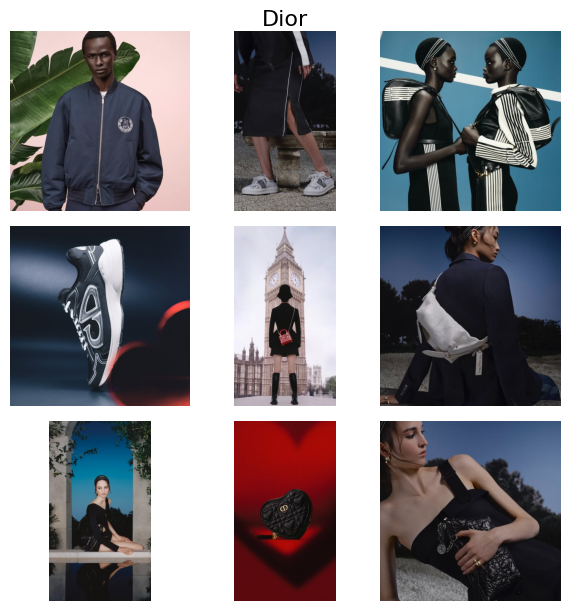

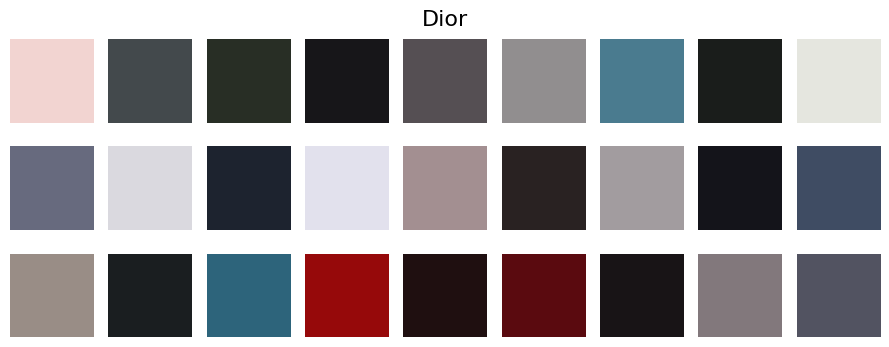

In [260]:
sample_brand_image('Dior')

In [263]:
df_brand_img.page_name.unique()

array(['CHANEL', 'Louis Vuitton', 'Dior', 'Gucci', 'Prada', 'BALENCIAGA',
       'SAINT LAURENT', 'Hermès', 'Burberry', 'H&M', 'ZARA', 'Bershka',
       'Mango', 'Massimo Dutti', 'Stradivarius', 'Pull&Bear', 'COS'],
      dtype=object)

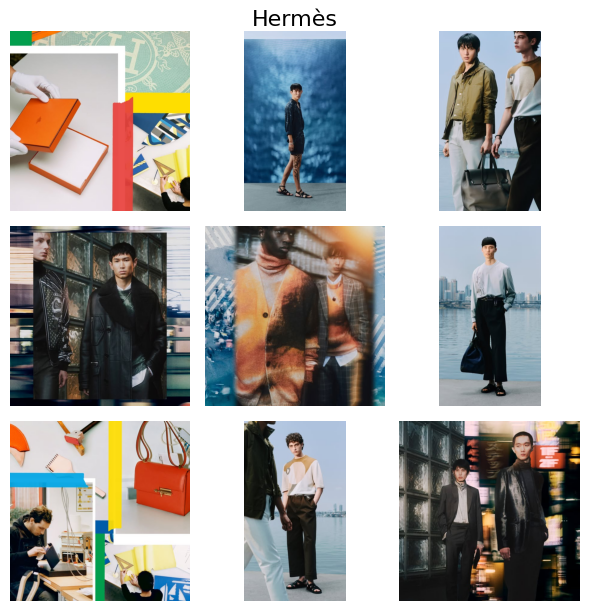

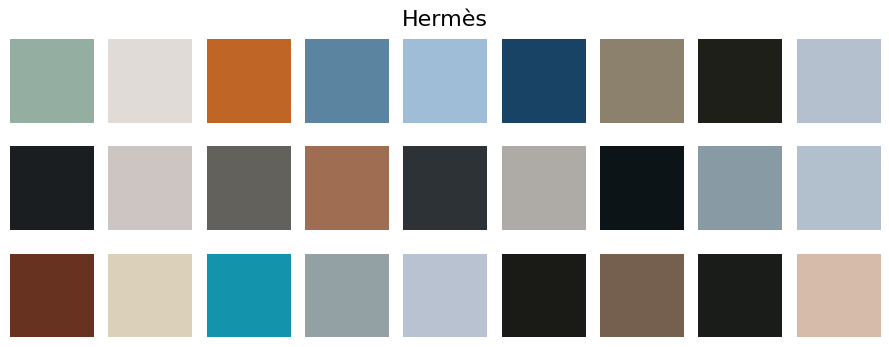

In [265]:
sample_brand_image('Hermès')

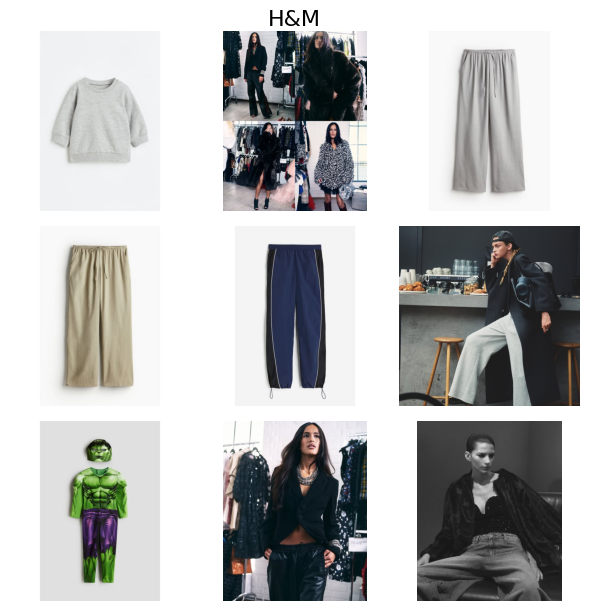

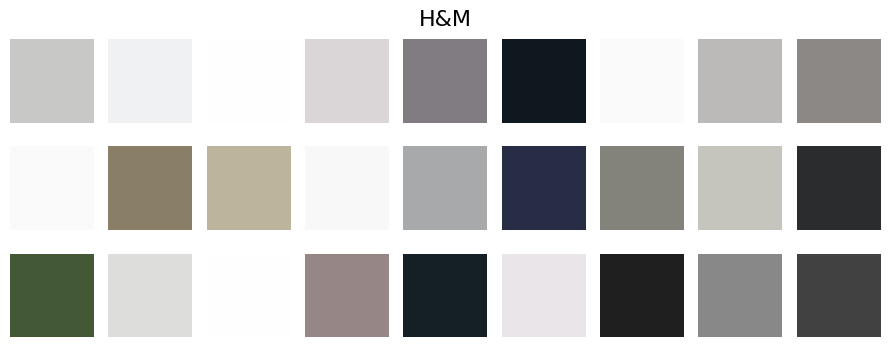

In [267]:
sample_brand_image('H&M')

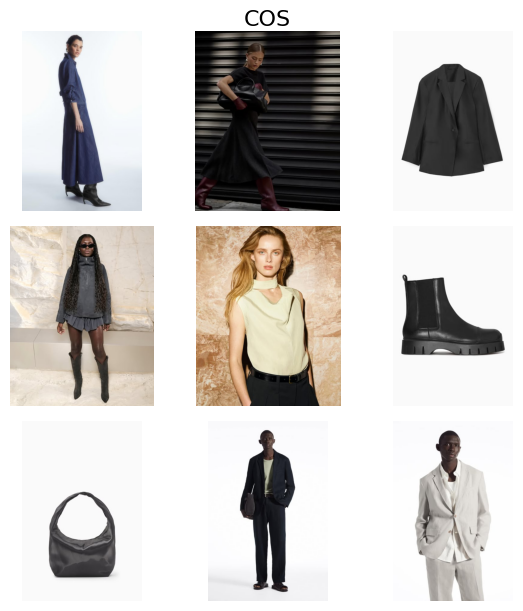

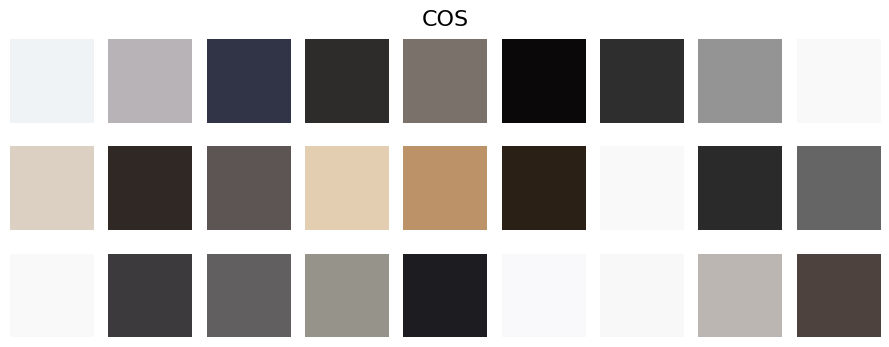

In [270]:
sample_brand_image('COS')

## 2. Do each company’s ads have a distinctive style that differentiates them from those of its competitors?

In [901]:
sc = StandardScaler()
content_cols = color_cols +  publisher_cols + language_cols + img_cols + topic_cols 

X_train_trans = sc.fit_transform(X_train[content_cols])
X_test_trans = sc.fit_transform(X_test[content_cols])

In [902]:
pca = PCA(n_components=2)
sc1 = StandardScaler()
X_pca = pca.fit_transform(X_train_trans)
y_train_text = X_train.merge(df_active[['id', 'page_name']], on='id', how='left')['page_name']


Text(0.5, 1.0, 'PCA of Fashion Ads')

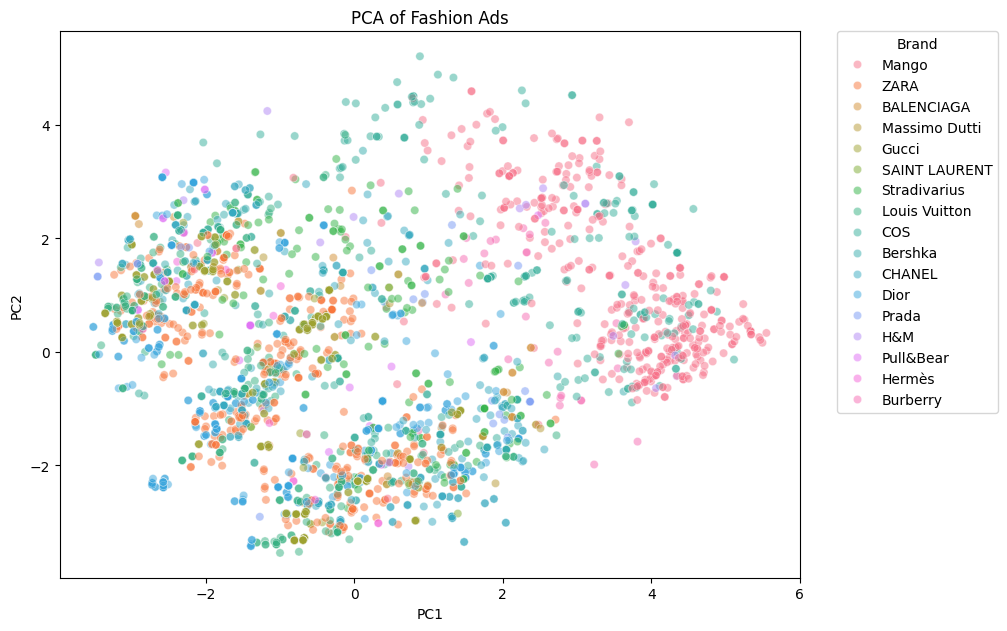

In [903]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=  X_pca[:,1],  hue=y_train_text, alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title="Brand")
plt.tight_layout()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Fashion Ads')

### Try 1: Clustering into 2 Groups

In [1020]:
def plot_pca_data(labels, title='Cluster',palette = None, X_pca = X_pca,plot_title=None):
    if palette == None:
        palette = sns.color_palette()[:2]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:,0], y=  X_pca[:,1],  hue=labels, alpha=0.5, palette=palette)
    plt.legend(title=title)
    plt.tight_layout()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    if plot_title == None:
        plot_title = 'PCA of Fashion Ads'
    plt.title(plot_title)

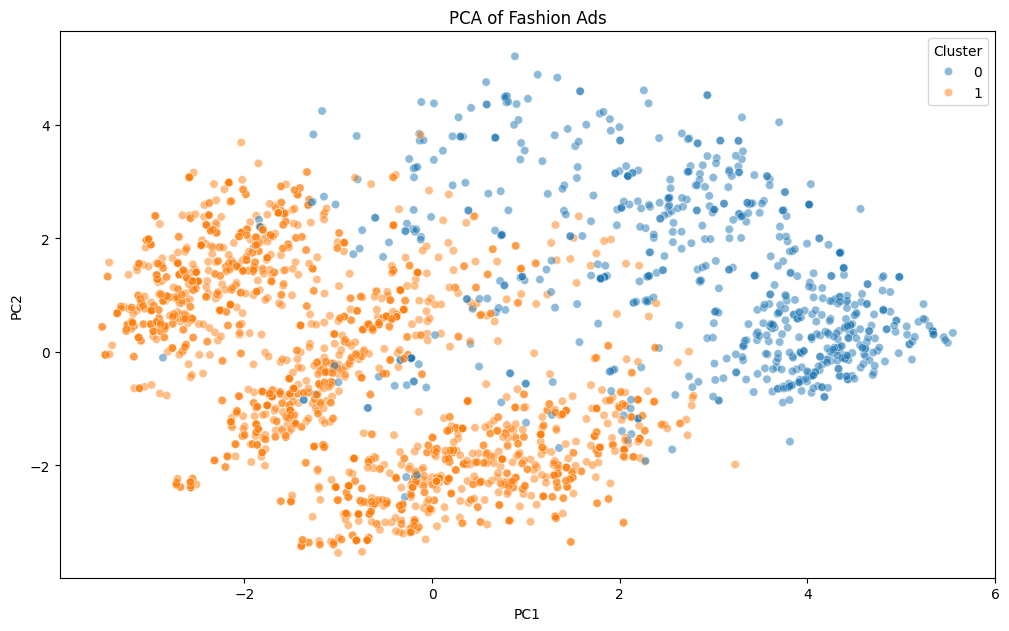

In [1021]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_train_trans)
plot_pca_data(gmm_labels)


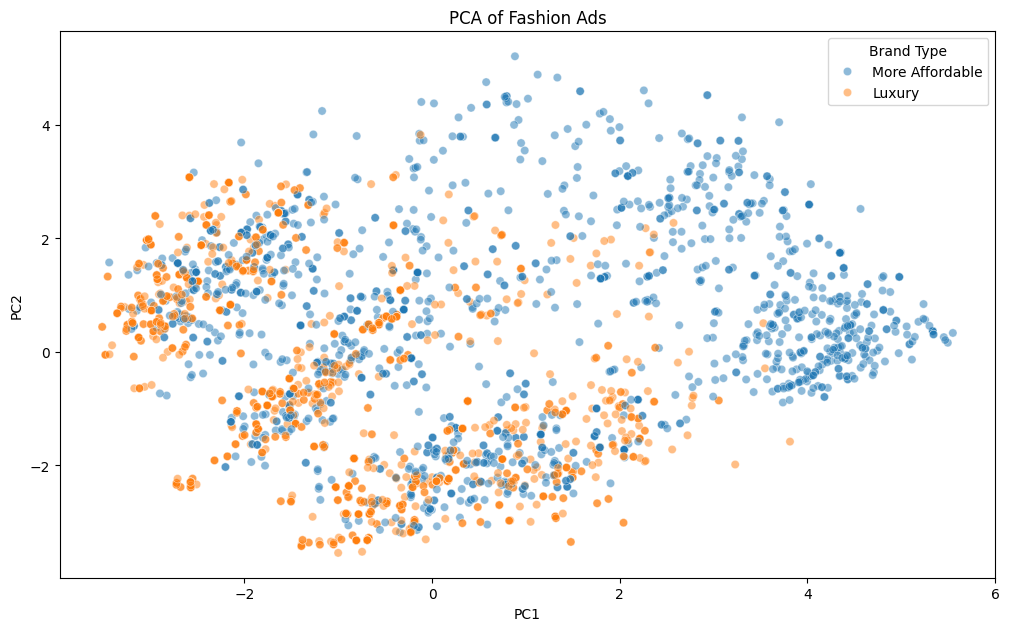

In [1022]:
brand_type = X_train.merge(df_active[['id', 'brand_type']], on='id', how='left')['brand_type'].str.title()
plot_pca_data(brand_type, 'Brand Type')
 

#### What distinguishes the two clusters?

In [1023]:
gmm_diff = gmm.means_[0] - gmm.means_[1]
gmm_diff = [ {n: d} for n, d in zip(content_cols, gmm_diff)]
sorted(gmm_diff, key=lambda x: list(x.values())[0], reverse=True)


[{'publisher_platform_messenger': 2.256663390560682},
 {'publisher_platform_audience_network': 2.180490841465014},
 {'topic_latest_armario': 1.5194314798987991},
 {'b1': 0.8995400308511106},
 {'g1': 0.8450497522127818},
 {'r1': 0.694943936375785},
 {'language_es': 0.5981709582029906},
 {'publisher_platform_facebook': 0.567008911633711},
 {'b2': 0.49150401636225527},
 {'g2': 0.46486181916821145},
 {'r2': 0.39062221322462254},
 {'language_en': 0.13097009308290739},
 {'b3': 0.1302662855589888},
 {'g3': 0.08239242558274074},
 {'r3': -0.018982632126355186},
 {'publisher_platform_instagram': -0.033167845208958546},
 {'language_it': -0.17852461370465267},
 {'language_fr': -0.17979730580638736},
 {'has_person': -0.23800870101026697},
 {'language_de': -0.26613628137625156},
 {'background_entropy': -0.975922963070657},
 {'topic_maison_collection': -1.2675897659027853}]

In [1039]:
for x in sorted(gmm_diff, key=lambda x: list(x.values())[0], reverse=True):
    for a,b in x.items():
        print(a, '&', round(b,3), "\\")

publisher_platform_messenger & 2.257 \
publisher_platform_audience_network & 2.18 \
topic_latest_armario & 1.519 \
b1 & 0.9 \
g1 & 0.845 \
r1 & 0.695 \
language_es & 0.598 \
publisher_platform_facebook & 0.567 \
b2 & 0.492 \
g2 & 0.465 \
r2 & 0.391 \
language_en & 0.131 \
b3 & 0.13 \
g3 & 0.082 \
r3 & -0.019 \
publisher_platform_instagram & -0.033 \
language_it & -0.179 \
language_fr & -0.18 \
has_person & -0.238 \
language_de & -0.266 \
background_entropy & -0.976 \
topic_maison_collection & -1.268 \


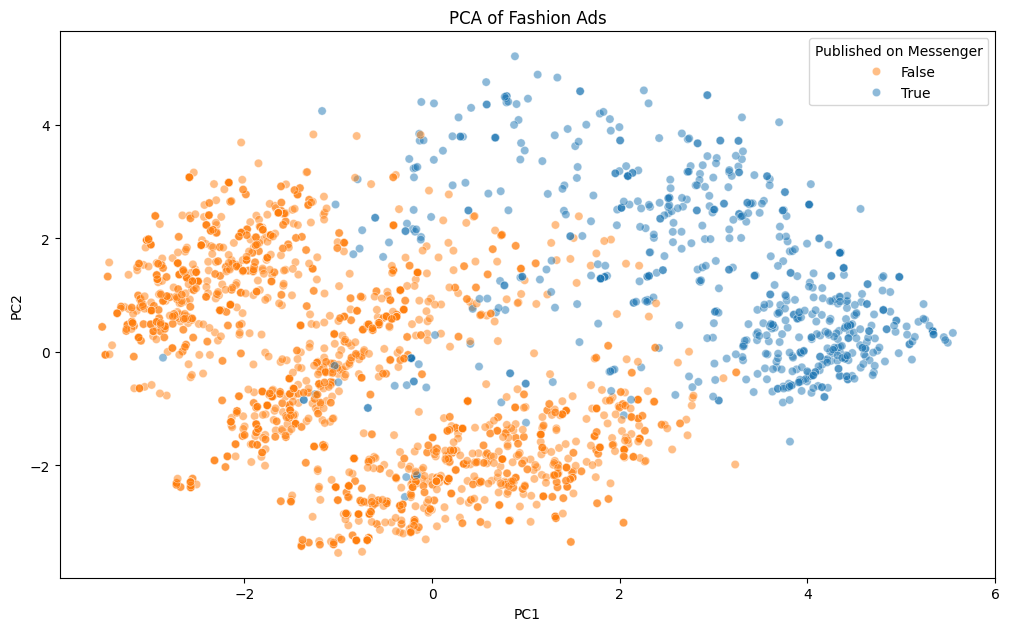

In [908]:
plot_pca_data(X_train.publisher_platform_messenger.astype(bool), title='Published on Messenger', 
              palette=sns.color_palette()[:2][::-1])

### Try 2: Clustering into 2 Groups without Publisher information 

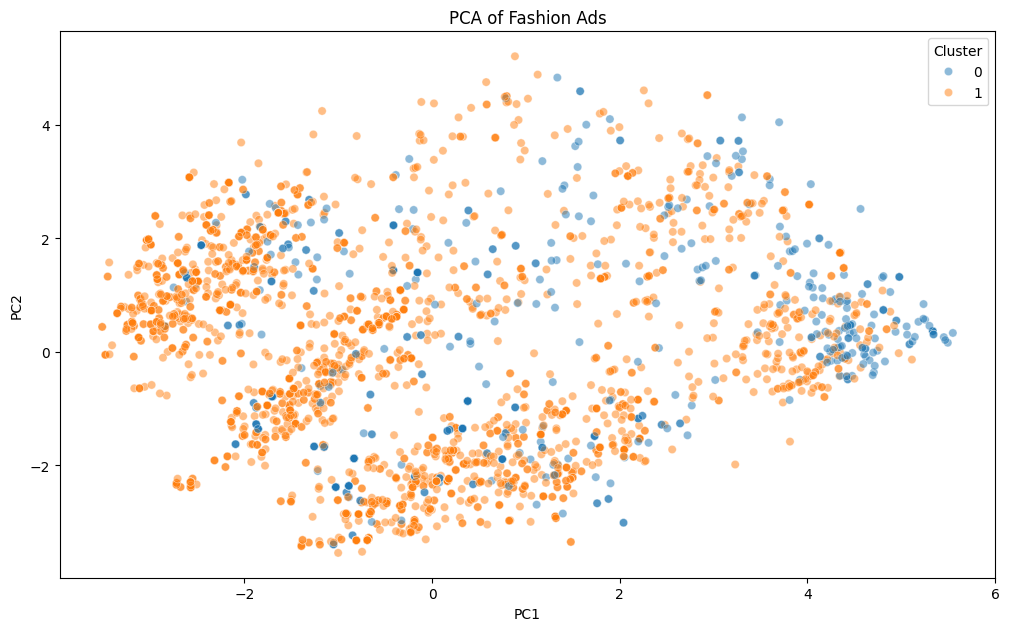

In [909]:
X_train_trans2 = sc.fit_transform(X_train[content_cols].drop(columns=publisher_cols))
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_train_trans2)
plot_pca_data(gmm_labels)


### Try 3: Clustering into 6 Groups/ Brands without Publisher Information

In [924]:
df_active[['page_name', 'id']].groupby('page_name')['id'].nunique().sort_values(ascending=False)

page_name
ZARA             500
Dior             500
Gucci            500
Mango            500
CHANEL           441
COS              431
Louis Vuitton    316
Stradivarius     229
Bershka          109
Pull&Bear         43
Massimo Dutti     39
Prada             34
Burberry          30
BALENCIAGA        29
H&M               24
Hermès            22
SAINT LAURENT     14
Name: id, dtype: int64

In [ ]:
brands_with_most_ads = list(df_active[['page_name', 'id']].groupby('page_name')['id'].nunique().sort_values(ascending=False).head(4).index)



In [936]:
#top_brands_indx = np.where(y_train_text.isin(brands_with_most_ads))[0]

top_brands_indx = np.where(y_train_text.isin(['Louis Vuitton', 'Gucci', 'Dior']))[0]

Text(0.5, 1.0, 'PCA of Fashion Ads')

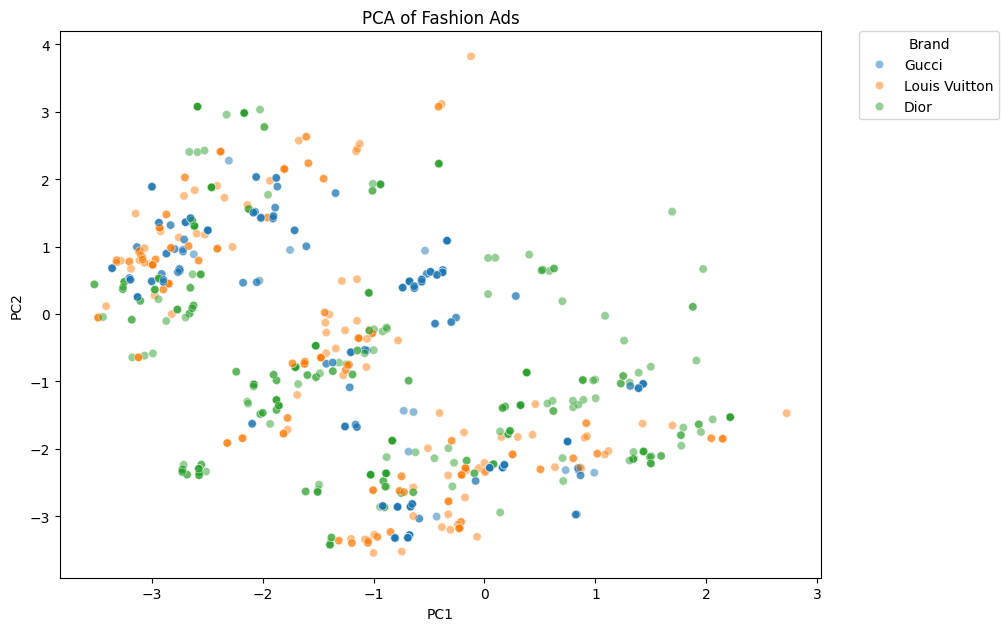

In [937]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[top_brands_indx,0], y=  X_pca[top_brands_indx,1],  hue=y_train_text[top_brands_indx], alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title="Brand")
plt.tight_layout()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Fashion Ads')

In [960]:
sc = StandardScaler()
X_train_trans3 = sc.fit_transform(X_train.loc[top_brands_indx, content_cols].drop(columns=publisher_cols))


C:\Users\chari\AppData\Local\Temp\ipykernel_152588\3646651912.py:5: UserWarning:

The palette list has more values (10) than needed (3), which may not be intended.



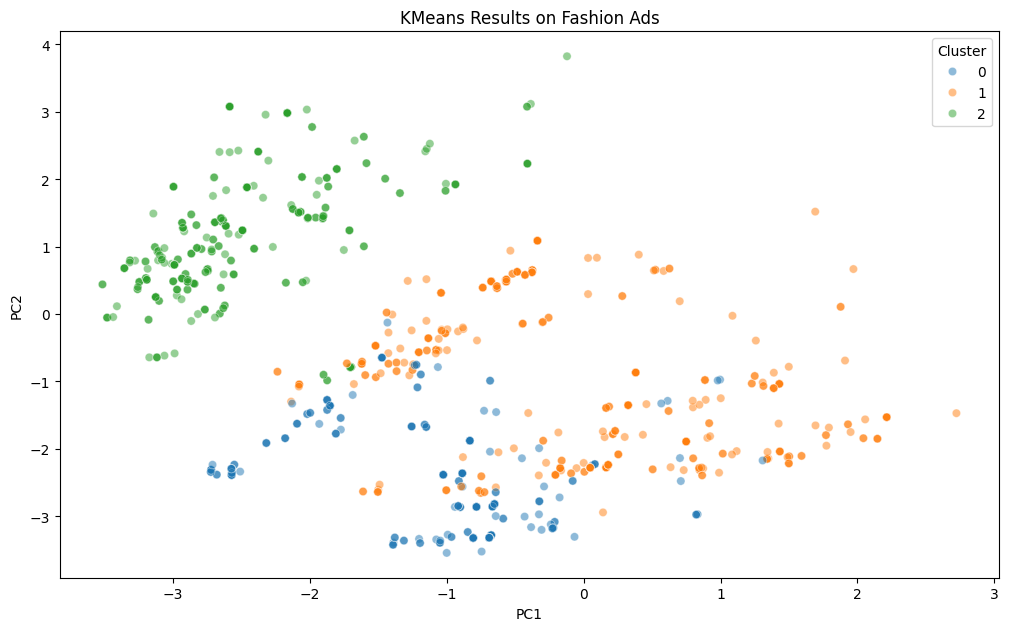

In [969]:
km = KMeans(n_clusters=3, random_state=42)
km_labels = km.fit_predict(X_train_trans3)
plot_pca_data(km_labels, palette=sns.color_palette(), X_pca=X_pca[top_brands_indx], plot_title= "KMeans Results on Fashion Ads")

C:\Users\chari\AppData\Local\Temp\ipykernel_152588\3646651912.py:5: UserWarning:

The palette list has more values (10) than needed (3), which may not be intended.



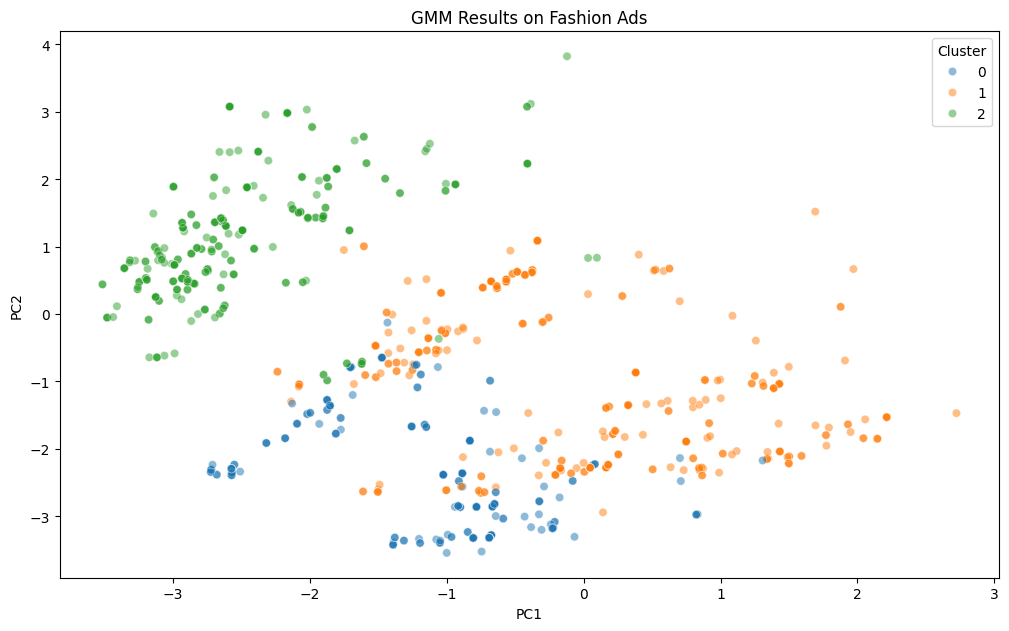

In [970]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_train_trans3)
plot_pca_data(gmm_labels, palette=sns.color_palette(), X_pca=X_pca[top_brands_indx], plot_title= "GMM Results on Fashion Ads")

In [985]:
true_labels_list = y_train_text[top_brands_indx].to_numpy()

for l in set(gmm_labels):
    ind = np.where(gmm_labels==l)[0]
    print(f"cluster {l}: ", Counter(true_labels_list[ind]))

cluster 0:  Counter({'Dior': 121, 'Gucci': 105, 'Louis Vuitton': 62})
cluster 1:  Counter({'Gucci': 177, 'Dior': 162, 'Louis Vuitton': 82})
cluster 2:  Counter({'Gucci': 115, 'Louis Vuitton': 110, 'Dior': 108})


C:\Users\chari\AppData\Local\Temp\ipykernel_152588\3646651912.py:5: UserWarning:

The palette list has more values (10) than needed (3), which may not be intended.



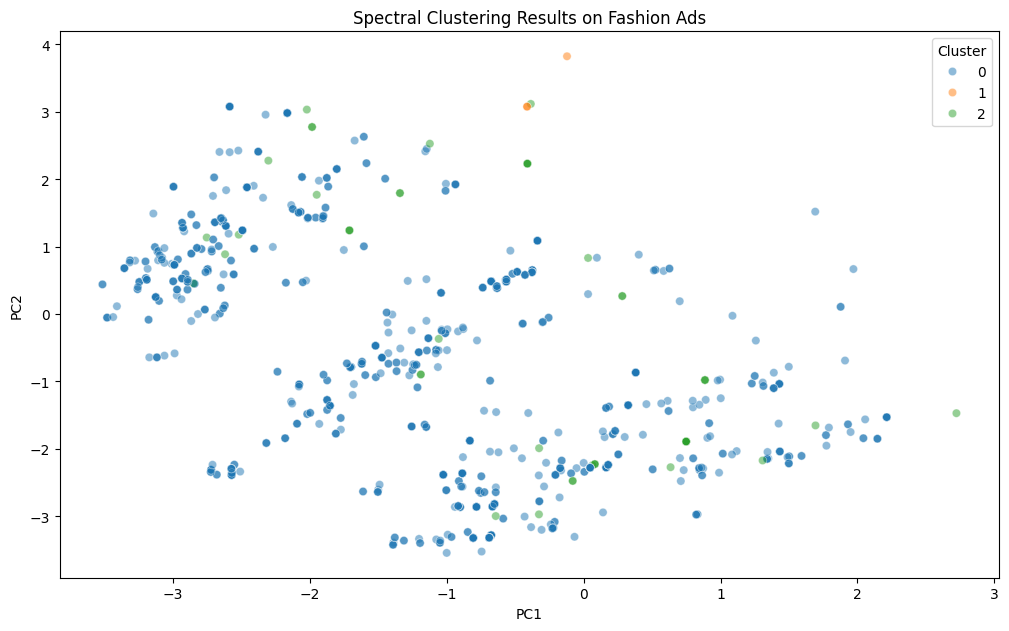

In [972]:
sc = SpectralClustering(n_clusters=3, random_state=42)
sc_labels = sc.fit_predict(X_train_trans3)
plot_pca_data(sc_labels, palette=sns.color_palette(), X_pca=X_pca[top_brands_indx],plot_title= "Spectral Clustering Results on Fashion Ads")


In [984]:
true_labels_list = y_train_text[top_brands_indx].to_numpy()

for l in set(sc_labels):
    ind = np.where(sc_labels==l)[0]
    print(f"cluster {l}: ", Counter(true_labels_list[ind]))

cluster 0:  Counter({'Gucci': 379, 'Dior': 371, 'Louis Vuitton': 239})
cluster 1:  Counter({'Louis Vuitton': 3})
cluster 2:  Counter({'Dior': 20, 'Gucci': 18, 'Louis Vuitton': 12})


c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\chari\AppData\Local\Temp\ipykernel_152588\3646651912.py:5: UserWarning:

The palette list has more values (10) than needed (1), which may not be intended.



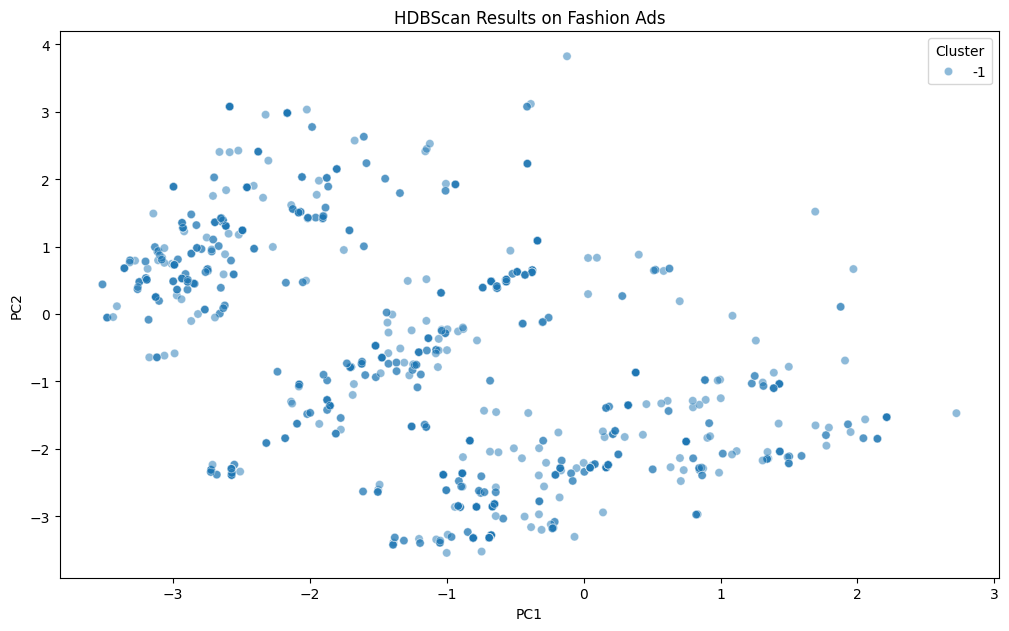

In [971]:
hdb = hdbscan.HDBSCAN(min_cluster_size = round(X_train_trans3.shape[0] * 0.05))
hdb_labels = hdb.fit_predict(X_train_trans3)
plot_pca_data(hdb_labels, palette=sns.color_palette(), X_pca=X_pca[top_brands_indx], plot_title= "HDBScan Results on Fashion Ads")

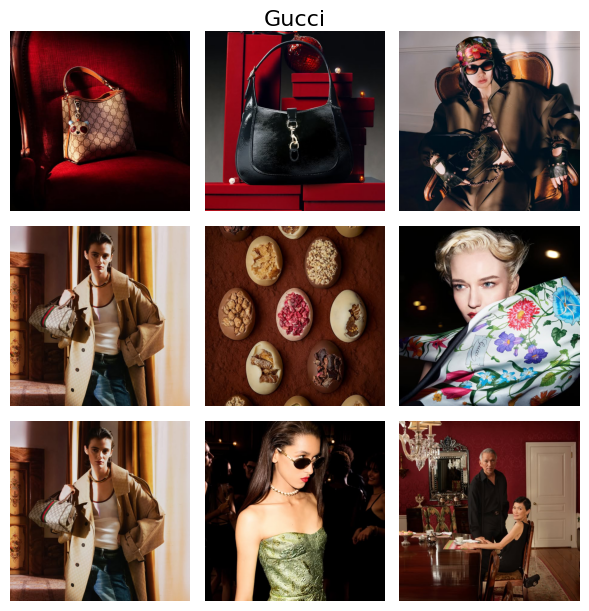

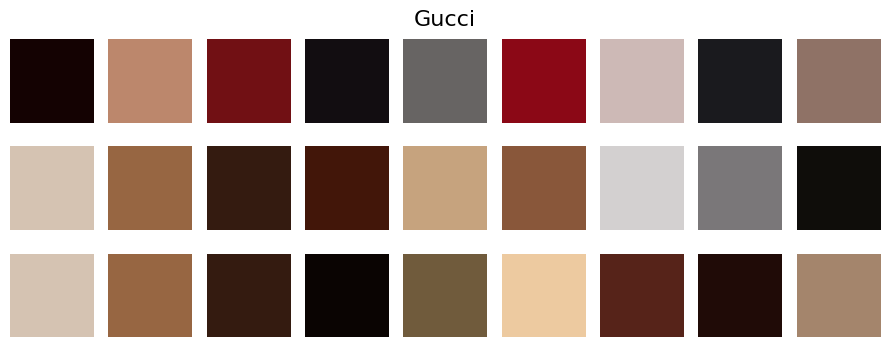

In [486]:
sample_brand_image('Gucci')

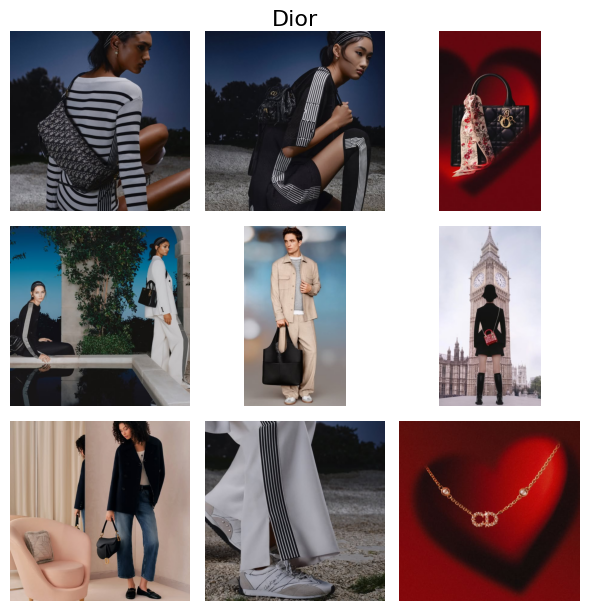

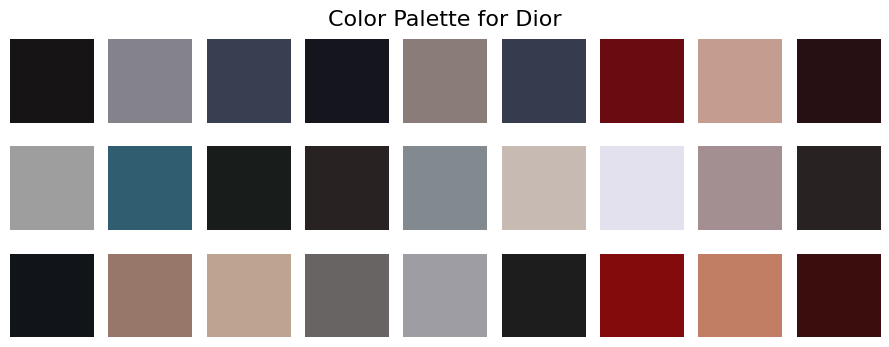

In [941]:
sample_brand_image('Dior')

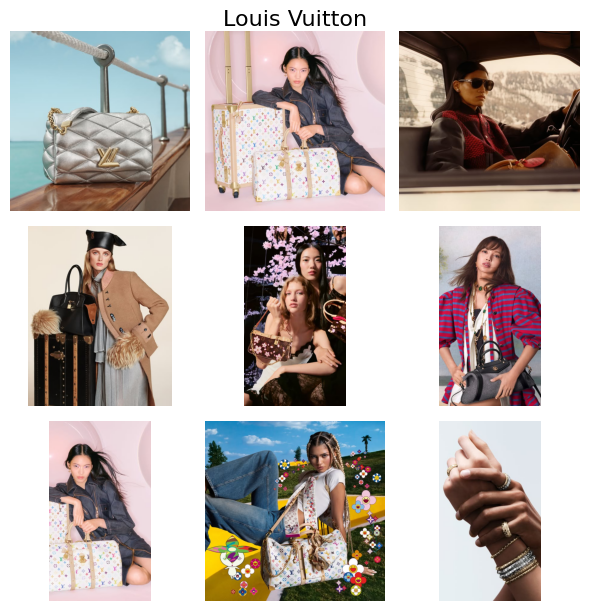

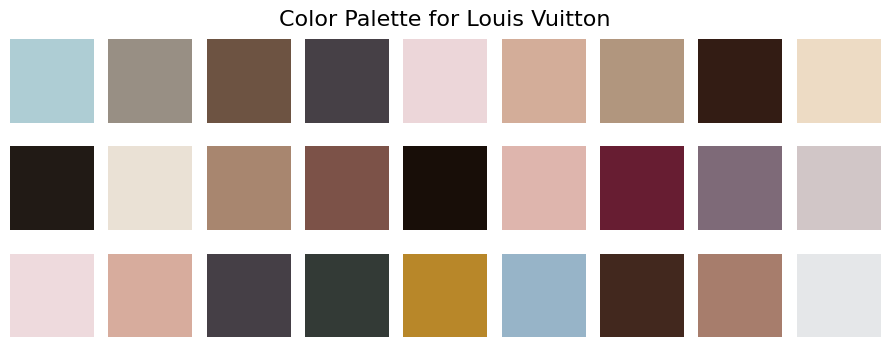

In [946]:
sample_brand_image('Louis Vuitton')

# 3.How does a company adjust its messaging and visuals for different demographics?

#### Quick EDA on Reach Data

In [389]:
df_active.groupby('target_gender')['id'].nunique() *0.8

target_gender
All      1558.4
Men       450.4
Women    1000.0
Name: id, dtype: float64

In [394]:
X_train[language_cols].sum()

language_de    435
language_en    702
language_es    343
language_fr    801
language_it    634
dtype: int64

In [392]:
X_train.groupby(['target_ages_lower', 'target_ages_upper'])['id'].nunique()

target_ages_lower  target_ages_upper
18                 34                      1
                   35                     83
                   40                     33
                   44                    226
                   45                     26
                   50                     34
                   54                    429
                   55                    197
                   64                     32
                   65                   1504
20                 50                      4
                   55                     21
                   65                     39
21                 54                      1
22                 55                      7
                   65                     80
25                 44                      3
                   54                      6
                   55                    103
                   60                     12
                   65                     56
27                

Looks like we have very concentrated samples around 18-65 age range, i.e. blanket targeting. 

In [399]:
df_reach2 = df_active[['page_name', 'id']].merge(df_reach, on='id')
df_reach2['total_reach'] = df_reach2['female'].fillna(0) + df_reach2['male'].fillna(0) + df_reach2['unknown'].fillna(0)
df_reach2

page_name                id age_range  female country  male  unknown  \
0        CHANEL   659995843340699     18-24     214      IT     0        0   
1        CHANEL   659995843340699     25-34    1123      IT     0        0   
2        CHANEL   659995843340699     35-44    2422      IT     0        0   
3        CHANEL   659995843340699     45-54    3750      IT     0        0   
4        CHANEL   659995843340699     55-64     397      IT     0        0   
...         ...               ...       ...     ...     ...   ...      ...   
18973       COS  1091602535472848     35-44    1304      FR     0        0   
18974       COS  1091602535472848     45-54    1557      FR     0        0   
18975       COS  1091602535472848     55-64    1856      FR     0        0   
18976       COS  1091602535472848       65+    1482      FR     0        0   
18977       COS   842341127393369     18-24       1      PL     0        0   

       total_reach  
0              214  
1             1123  
2             2422  
3             3750  
4              397  
...            ...  
18973         1304  
18974         1557  
18975         1856  
18976         1482  
18977            1  

[18978 rows x 8 columns]

In [459]:
code_to_country = {
    'IT': 'Italy',
    'FR': 'France',
    'PT': 'Portugal',
    'ES': 'Spain',
    'DE': 'Germany',
    'BE': 'Belgium',
    'SE': 'Sweden',
    'NL': 'Netherlands',
    'IE': 'Ireland',
    'DK': 'Denmark',
    'CZ': 'Czech Republic',
    'SI': 'Slovenia',
    'GR': 'Greece',
    'PL': 'Poland',
    'RO': 'Romania',
    'AT': 'Austria',
    'BG': 'Bulgaria',
    'LU': 'Luxembourg',
    'FI': 'Finland',
    'CY': 'Cyprus',
    'HR': 'Croatia',
    'LT': 'Lithuania',
    'EE': 'Estonia',
    'LV': 'Latvia',
    'SK': 'Slovakia',
    'HU': 'Hungary'
}
df_reach2['country2'] = df_reach2.country.apply(lambda x: code_to_country[x])
df_reach2.groupby(['page_name','country2'])['total_reach'].sum().sort_values(ascending=False).reset_index().to_csv('../data_clean/country_reach.csv')

In [460]:
df_reach2[['page_name', 'female','male','unknown']]\
        .melt(id_vars='page_name', value_name= 'reach', var_name= 'gender', value_vars=['female','male','unknown'])\
        .fillna(0).to_csv('../data_clean/gender_reach.csv')

In [461]:
df_reach2[['page_name', 'age_range','total_reach']].to_csv('../data_clean/age_reach.csv')

Creating a consolidated table so that the filters across all charts work ...

In [787]:
df_reach2[['page_name', 'id', 'age_range', 'country2', 'female','male','unknown']]\
    .melt(id_vars=['page_name', 'id', 'age_range', 'country2'], 
          value_name= 'total_eu_reach', 
          var_name= 'gender', 
          value_vars=['female','male','unknown']).to_csv('../data_clean/all_reach.csv')

### Gender

##### Assuming that an ad is targeted for all gender, what's its probability of reaching male vs female audience? 

In [552]:
df_reach2['male_female_reach'] =df_reach2['female'].fillna(0) + df_reach2['male'].fillna(0)
# df_reach2['prob_female_reach'] =  df_reach2['female'].fillna(0) / df_reach2['male_female_reach']

In [555]:
df_reach3 = df_reach2.groupby(['id'])[['female', 'male', 'male_female_reach']].sum().reset_index()
df_reach3['prob_female_reach'] =  df_reach3['female'].fillna(0) / df_reach3['male_female_reach']
df_reach3.head()

id  female   male  male_female_reach  prob_female_reach
0  211490241986143     313  17850              18163           0.017233
1  235519282952349   46201      0              46201           1.000000
2  255730290959477    9117      0               9117           1.000000
3  260954830376732   64746      0              64746           1.000000
4  264553996745105      20    147                167           0.119760

In [593]:
all_gender_train_indx = np.where(X_train.id.isin(df_active.loc[df_active.target_gender =='All','id']))[0]
all_gender_test_indx = np.where(X_test.id.isin(df_active.loc[df_active.target_gender =='All','id']))[0]

X_train_all_gender = X_train.iloc[all_gender_train_indx]
X_test_all_gender = X_test.iloc[all_gender_test_indx]

y_train_all_gender = X_train_all_gender[['id']].merge(df_reach3, on='id')['prob_female_reach']
y_test_all_gender =X_test_all_gender[['id']].merge(df_reach3, on='id')['prob_female_reach']


In [986]:
content_cols

['r1',
 'r2',
 'r3',
 'g1',
 'g2',
 'g3',
 'b1',
 'b2',
 'b3',
 'publisher_platform_facebook',
 'publisher_platform_instagram',
 'publisher_platform_audience_network',
 'publisher_platform_messenger',
 'language_de',
 'language_en',
 'language_es',
 'language_fr',
 'language_it',
 'has_person',
 'background_entropy',
 'topic_latest_armario',
 'topic_maison_collection']

In [987]:
sc = StandardScaler()
X_train_all_gender_trans = sc.fit_transform( X_train_all_gender[content_cols])
X_test_all_gender_trans = sc.transform( X_test_all_gender[content_cols])
print(X_train_all_gender_trans.shape, X_test_all_gender_trans.shape)

(1518, 22) (381, 22)


In [988]:
X_train_all_gender_trans_2 = sm.add_constant(X_train_all_gender_trans)
X_test_all_gender_trans_2 = sm.add_constant(X_test_all_gender_trans, has_constant='add')   

print(X_train_all_gender_trans_2.shape, X_test_all_gender_trans_2.shape)

glm = sm.GLM(y_train_all_gender.values.ravel(), X_train_all_gender_trans_2, family=sm.families.Binomial())
result = glm.fit()

y_pred_glm = result.predict(X_test_all_gender_trans_2)
print(mean_squared_error(y_test_all_gender, y_pred_glm))
print(result.summary())

(1518, 23) (381, 23)
0.03913846527123677
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1518
Model:                            GLM   Df Residuals:                     1496
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -562.36
Date:                Sun, 27 Apr 2025   Deviance:                       330.74
Time:                        13:46:23   Pearson chi2:                     371.
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1077
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [997]:
summary_table = pd.DataFrame({
    'Feature':  content_cols,
    'Coefficient': result.params[1:],
    'Std_Error': result.bse[1:],
    'z_value': result.tvalues[1:],
    'p_value': result.pvalues[1:],
    'stat_sig_90': result.pvalues[1:]<0.1,
    'ci_95_lower' : result.conf_int()[1:,0],
    'ci_95_upper' : result.conf_int()[1:,1],
    'Odds_Ratio': np.exp(result.params[1:])
})

summary_table.sort_values(by = 'p_value', ascending=True)

Feature  Coefficient  Std_Error   z_value  \
18                           has_person     0.243795   0.075484  3.229755   
14                          language_en    -0.155681   0.057299 -2.716992   
6                                    b1     1.322184   0.512760  2.578565   
15                          language_es     0.193274   0.077016  2.509523   
12         publisher_platform_messenger     0.365899   0.185207  1.975623   
11  publisher_platform_audience_network     0.344548   0.184527  1.867194   
21              topic_maison_collection    -0.142640   0.079585 -1.792306   
3                                    g1    -1.205623   0.676634 -1.781793   
20                 topic_latest_armario    -0.142461   0.111857 -1.273596   
2                                    r3     0.301525   0.237539  1.269369   
19                   background_entropy    -0.122218   0.100555 -1.215430   
8                                    b3    -0.451167   0.449060 -1.004693   
7                                    b2    -0.482622   0.489409 -0.986132   
1                                    r2     0.299055   0.321586  0.929935   
10         publisher_platform_instagram    -0.060054   0.064956 -0.924534   
9           publisher_platform_facebook    -0.058114   0.072527 -0.801284   
13                          language_de     0.035167   0.054508  0.645172   
16                          language_fr    -0.032502   0.052010 -0.624927   
5                                    g3     0.313851   0.560350  0.560098   
4                                    g2     0.265167   0.707369  0.374863   
0                                    r1    -0.039056   0.322540 -0.121089   
17                          language_it    -0.004271   0.051579 -0.082813   

     p_value  stat_sig_90  ci_95_lower  ci_95_upper  Odds_Ratio  
18  0.001239         True     0.095849     0.391742    1.276083  
14  0.006588         True    -0.267984    -0.043377    0.855833  
6   0.009921         True     0.317194     2.327174    3.751605  
15  0.012089         True     0.042325     0.344223    1.213215  
12  0.048197         True     0.002900     0.728897    1.441809  
11  0.061874         True    -0.017118     0.706214    1.411352  
21  0.073084         True    -0.298623     0.013343    0.867066  
3   0.074783         True    -2.531802     0.120556    0.299505  
20  0.202807        False    -0.361697     0.076775    0.867222  
2   0.204309        False    -0.164043     0.767093    1.351919  
19  0.224202        False    -0.319303     0.074867    0.884955  
8   0.315045        False    -1.331308     0.428974    0.636884  
7   0.324068        False    -1.441845     0.476602    0.617163  
1   0.352405        False    -0.331243     0.929352    1.348583  
10  0.355208        False    -0.187367     0.067258    0.941713  
9   0.422967        False    -0.200264     0.084035    0.943542  
13  0.518816        False    -0.071666     0.142000    1.035793  
16  0.532019        False    -0.134440     0.069435    0.968020  
5   0.575413        False    -0.784415     1.412117    1.368686  
4   0.707762        False    -1.121251     1.651585    1.303648  
0   0.903620        False    -0.671222     0.593110    0.961697  
17  0.934000        False    -0.105365     0.096822    0.995738

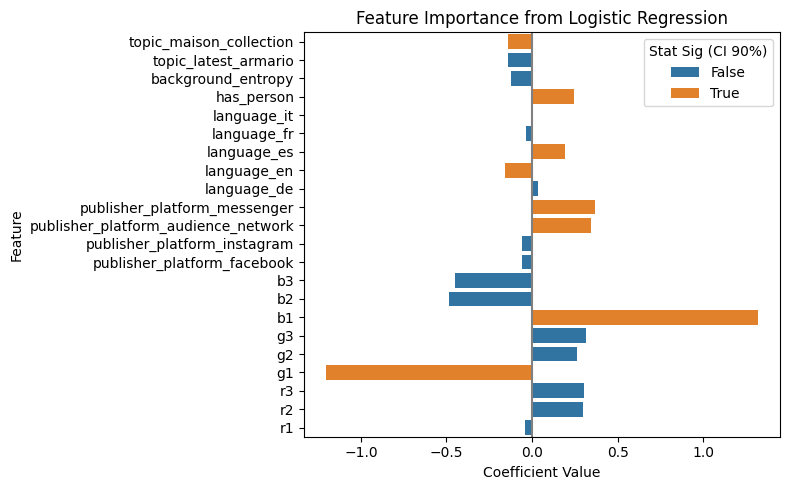

In [998]:
plt.figure(figsize=(8, 5))
ax= sns.barplot(y = summary_table['Feature'], x= summary_table['Coefficient'], hue=summary_table['stat_sig_90'] )
ax.legend(title='Stat Sig (CI 90%)' )
plt.axvline(x=0, color='grey', linestyle='-')  # optional: add a vertical line at 0
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

In [653]:
df_reach4 = df_reach3.merge(df_active.loc[df_active.target_gender =='All','id'], on='id').merge(df_brand_img[['id']], on='id')
popular_ads_men = df_reach4[df_reach4.male_female_reach > 1000].sort_values(by=['prob_female_reach','male_female_reach'], ascending=[True, False]).head(10).id
popular_ads_women = df_reach4[df_reach4.male_female_reach > 1000].sort_values(by=['prob_female_reach','male_female_reach'], ascending=[False, False]).head(10).id


In [657]:
def sample_image_by_id(l,   t):
    figure, ax = plt.subplots(3,3, figsize=(6, 6))
    plot_df = df_brand_img[df_brand_img['id'].isin(l)].sample(9).reset_index(drop=True)

    for i, row in plot_df.iterrows():
        image_path = f'../data_clean/unique_imgs2/{row["ref_id"]}.png'
        img = Image.open(image_path)
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')

    plt.tight_layout()
    plt.suptitle(t, fontsize=16, y=1.01)
    plt.show()

    plot_df2 = plot_df.merge(df_image, left_on='ref_id', right_on='id', how='left')
    figure, ax = plt.subplots(3, 3 * 3, figsize=(9, 3.5))  # Adjusted figure size for better visibility

    for ind, row in plot_df2.iterrows():
        j = ind % 3 * 3
        i = ind // 3

        for c in [1, 2, 3]:
            color = row[[f'r{c}', f'g{c}', f'b{c}']].values.astype(int)
            color = color.reshape(1, 1, 3)
            ax[i, j + c - 1].imshow(color)
            ax[i, j + c - 1].axis('off')

    plt.tight_layout()
    plt.suptitle('Color Palettes of ' +t, fontsize=16, y=1.01)
    plt.show()

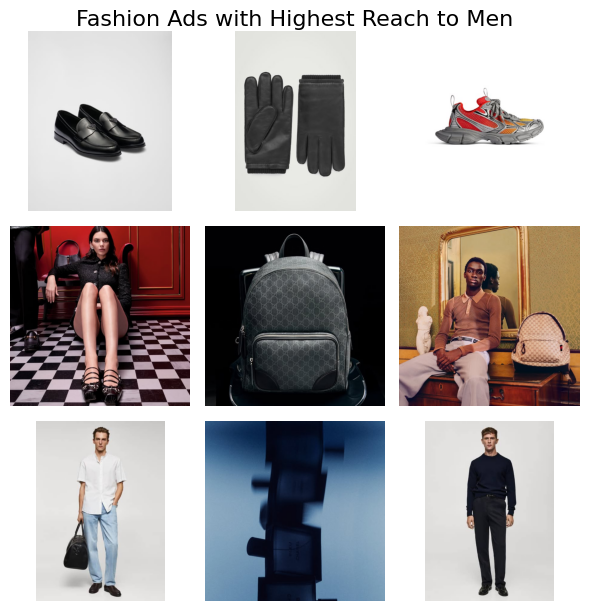

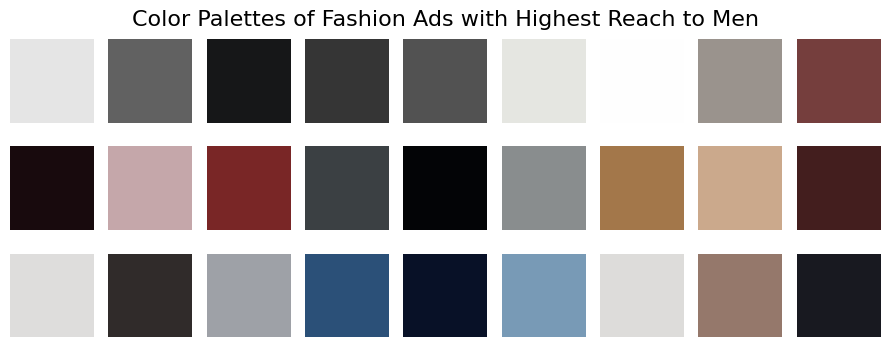

In [1003]:
sample_image_by_id(list(popular_ads_men.values), 'Fashion Ads with Highest Reach to Men')

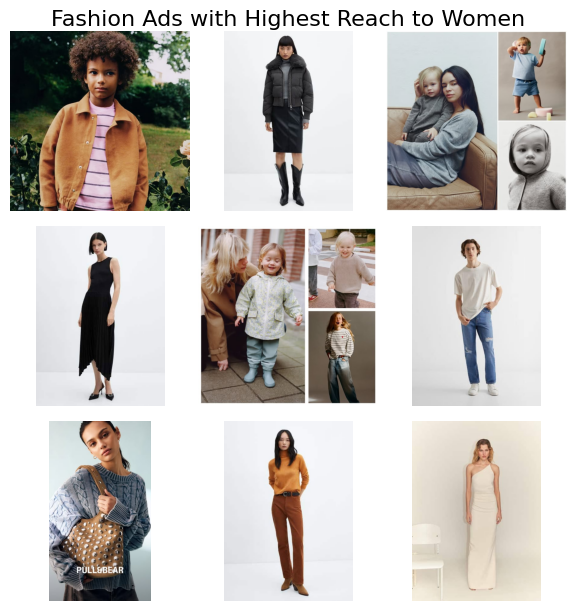

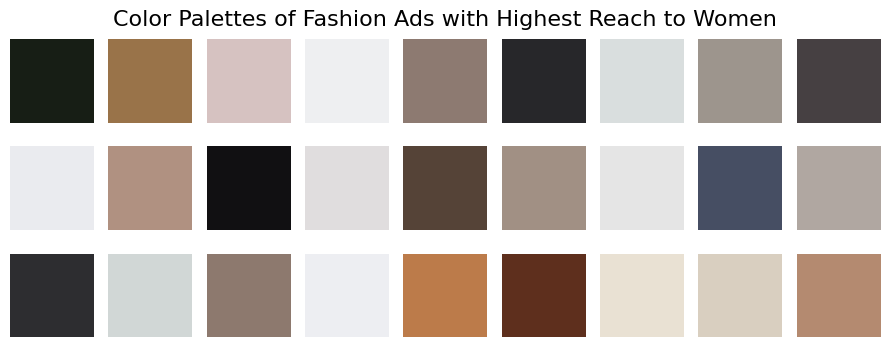

In [999]:
sample_image_by_id(list(popular_ads_women.values), 'Fashion Ads with Highest Reach to Women')

### Age

#### Assuming that an ad is targeted from age 18 to 65, what's the probability it will reach each age bracket? 

In [1004]:
df_reach5 = df_reach2[df_reach2.age_range != 'Unknown'].groupby(['id','age_range'])['total_reach'].sum().reset_index()
df_reach5 = df_reach5.pivot_table(index='id', values = 'total_reach', columns= 'age_range').fillna(0)
df_reach5['all_ages'] = df_reach5.sum(axis=1)
age_cols =  ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
for ar in age_cols:
    df_reach5[ar] = df_reach5[ar] /df_reach5['all_ages'] 
df_reach5 = df_reach5[age_cols].reset_index()
df_reach5

age_range                 id     18-24     25-34     35-44     45-54  \
0            211490241986143  0.079544  0.383959  0.305075  0.208521   
1            235519282952349  0.148027  0.352482  0.177247  0.115365   
2            255730290959477  0.055501  0.211363  0.405067  0.328068   
3            260954830376732  0.000000  0.617660  0.350199  0.032126   
4            264553996745105  0.053571  0.547619  0.244048  0.065476   
...                      ...       ...       ...       ...       ...   
3756       28594780770168981  0.023644  0.545743  0.396274  0.023143   
3757       28668469296133012  0.043470  0.332553  0.286919  0.213422   
3758       28821354160841688  0.061335  0.489527  0.267609  0.110031   
3759       28890863807225303  0.074156  0.408957  0.291483  0.175477   
3760       29325192860405066  0.014266  0.159720  0.274685  0.350769   

age_range     55-64       65+  
0          0.020918  0.001982  
1          0.115365  0.091513  
2          0.000000  0.000000  
3          0.000000  0.000015  
4          0.047619  0.041667  
...             ...       ...  
3756       0.006433  0.004762  
3757       0.090274  0.033362  
3758       0.050906  0.020592  
3759       0.036711  0.013216  
3760       0.155245  0.045315  

[3761 rows x 7 columns]

In [1005]:

all_age_train_indx = (X_train.target_ages_lower==18) & (X_train.target_ages_upper==65)
all_age_test_indx = (X_test.target_ages_lower==18) & (X_test.target_ages_upper==65)


X_train_all_age = X_train.loc[all_age_train_indx]
X_test_all_age = X_test.loc[all_age_test_indx]

y_train_all_age = X_train_all_age[['id']].merge(df_reach5, on='id')[age_cols]
y_test_all_age =X_test_all_age[['id']].merge(df_reach5, on='id')[age_cols]

print(y_train_all_age.shape, y_test_all_age.shape)

(1504, 6) (363, 6)


In [1006]:
sc = StandardScaler()
X_train_all_age_trans = sc.fit_transform( X_train_all_age[content_cols])
X_test_all_age_trans = sc.transform( X_test_all_age[content_cols])
print(X_train_all_age_trans.shape, X_test_all_age_trans.shape)

X_train_all_age_trans_2 = sm.add_constant(X_train_all_age_trans)
X_test_all_age_trans_2 = sm.add_constant(X_test_all_age_trans, has_constant='add')   

print(X_train_all_age_trans_2.shape, X_test_all_age_trans_2.shape)

(1504, 22) (363, 22)
(1504, 23) (363, 23)


In [1007]:
# Fit multinomial logit model
mnlogit = sm.MNLogit(y_train_all_age, X_train_all_age_trans_2)
result2 = mnlogit.fit()

y_pred_probs = result2.predict(X_test_all_age_trans_2)
print(mean_squared_error(y_test_all_age, y_pred_probs))

print(result2.summary())

Optimization terminated successfully.
         Current function value: 1.617595
         Iterations 6
0.007688461732111671
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1504
Model:                        MNLogit   Df Residuals:                     1394
Method:                           MLE   Df Model:                          105
Date:                Sun, 27 Apr 2025   Pseudo R-squ.:                 -0.1923
Time:                        14:37:38   Log-Likelihood:                -2432.9
converged:                       True   LL-Null:                       -2040.5
Covariance Type:            nonrobust   LLR p-value:                     1.000
   y=25-34       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2279      0.108     11.385      0.000       1.017       1.439
x1      

c:\Users\chari\miniconda3\envs\yolovenv\lib\site-packages\statsmodels\discrete\discrete_model.py:5475: RuntimeWarning:

invalid value encountered in sqrt



In [ ]:
print(result2.model._ynames_map)  


{0: '18-24', 1: '25-34', 2: '35-44', 3: '45-54', 4: '55-64', 5: '65+'}


In [1008]:
summary_table2_coeff = result2.params.rename(columns = result2.model._ynames_map).iloc[1:, :]
summary_table2_coeff['Feature'] = content_cols
summary_table2_coeff

18-24     25-34     35-44     45-54     55-64  \
x1  -0.100563 -0.117039 -0.079092 -0.336257 -0.537471   
x2  -0.058900 -0.030030  0.036221  0.067712 -0.049178   
x3   0.209803  0.247784  0.197720  0.248937  0.604598   
x4   0.275278  0.157197  0.000248  0.433801  0.488185   
x5   0.139300 -0.094163 -0.167101 -0.402272 -0.092498   
x6  -0.642025 -0.760094 -0.801255 -0.870812 -1.216566   
x7  -0.065063  0.063164  0.212293  0.033910  0.166573   
x8   0.022429  0.225427  0.223023  0.439146  0.232023   
x9   0.508558  0.559520  0.662352  0.687130  0.727522   
x10  0.207083  0.294283  0.295429  0.291459  0.295157   
x11 -0.035293 -0.135110 -0.189481 -0.224651 -0.266582   
x12  0.188817  0.166696  0.101329  0.102234  0.052264   
x13  0.092822  0.171906  0.254773  0.166915  0.019635   
x14  0.123172  0.079546 -0.049354 -0.038314 -0.096143   
x15 -0.169961 -0.180605 -0.147193 -0.152962 -0.158651   
x16 -0.047464  0.026373  0.131704  0.107167  0.078962   
x17  0.043976  0.018633  0.026398  0.041680  0.146793   
x18  0.076309  0.078369  0.034308  0.037982 -0.001144   
x19 -0.002380  0.024397  0.025443 -0.039611 -0.129274   
x20  0.094457  0.059585  0.103312  0.159978  0.155633   
x21 -0.233788 -0.300713 -0.235025 -0.123389  0.040496   
x22 -0.106537 -0.141459 -0.120924 -0.036272  0.097844   

                                 Feature  
x1                                    r1  
x2                                    r2  
x3                                    r3  
x4                                    g1  
x5                                    g2  
x6                                    g3  
x7                                    b1  
x8                                    b2  
x9                                    b3  
x10          publisher_platform_facebook  
x11         publisher_platform_instagram  
x12  publisher_platform_audience_network  
x13         publisher_platform_messenger  
x14                          language_de  
x15                          language_en  
x16                          language_es  
x17                          language_fr  
x18                          language_it  
x19                           has_person  
x20                   background_entropy  
x21                 topic_latest_armario  
x22              topic_maison_collection

In [1009]:
summary_table2_pvalues = result2.pvalues.rename(columns = result2.model._ynames_map).iloc[1:, :]
summary_table2_pvalues['Feature'] = content_cols
for age in ['18-24', '25-34',  '35-44',   '45-54',  '55-64']:
    summary_table2_pvalues[age +'_stat_sig_90'] = summary_table2_pvalues[age]<0.1

summary_table2_pvalues

18-24     25-34     35-44     45-54     55-64  \
x1   0.830110  0.804933  0.871295  0.552196  0.450452   
x2   0.885621  0.941537  0.930338  0.881555  0.932027   
x3   0.642779  0.583982  0.665533  0.614762  0.276341   
x4   0.805733  0.889678  0.999831  0.745485  0.771420   
x5   0.882146  0.920643  0.861909  0.704708  0.945034   
x6   0.531011  0.460368  0.443910  0.446271  0.356850   
x7   0.939355  0.942154  0.814130  0.973468  0.896293   
x8   0.973787  0.744618  0.753017  0.579403  0.815665   
x9   0.489548  0.452310  0.385542  0.416125  0.469851   
x10  0.042129  0.006429  0.009406  0.026509  0.072553   
x11  0.823549  0.372736  0.211695  0.150797  0.106685   
x12  0.518090  0.572394  0.738992  0.762060  0.901182   
x13  0.752520  0.563765  0.407774  0.625230  0.963309   
x14  1.000000  1.000000  1.000000  1.000000       NaN   
x15       NaN  1.000000  1.000000  1.000000       NaN   
x16       NaN  1.000000  1.000000  1.000000       NaN   
x17       NaN  1.000000  1.000000  1.000000       NaN   
x18       NaN  1.000000  1.000000  1.000000       NaN   
x19  0.983878  0.838623  0.836542  0.772495  0.437550   
x20  0.495684  0.674092  0.481210  0.329803  0.442388   
x21  0.185095  0.093013  0.200580  0.549699  0.874772   
x22  0.484434  0.362142  0.453985  0.839704  0.646171   

                                 Feature  18-24_stat_sig_90  \
x1                                    r1              False   
x2                                    r2              False   
x3                                    r3              False   
x4                                    g1              False   
x5                                    g2              False   
x6                                    g3              False   
x7                                    b1              False   
x8                                    b2              False   
x9                                    b3              False   
x10          publisher_platform_facebook               True   
x11         publisher_platform_instagram              False   
x12  publisher_platform_audience_network              False   
x13         publisher_platform_messenger              False   
x14                          language_de              False   
x15                          language_en              False   
x16                          language_es              False   
x17                          language_fr              False   
x18                          language_it              False   
x19                           has_person              False   
x20                   background_entropy              False   
x21                 topic_latest_armario              False   
x22              topic_maison_collection              False   

     25-34_stat_sig_90  35-44_stat_sig_90  45-54_stat_sig_90  \
x1               False              False              False   
x2               False              False              False   
x3               False              False              False   
x4               False              False              False   
x5               False              False              False   
x6               False              False              False   
x7               False              False              False   
x8               False              False              False   
x9               False              False              False   
x10               True               True               True   
x11              False              False              False   
x12              False              False              False   
x13              False              False              False   
x14              False              False              False   
x15              False              False              False   
x16              False              False              False   
x17              False              False              False   
x18              False              False              False   
x19              False        

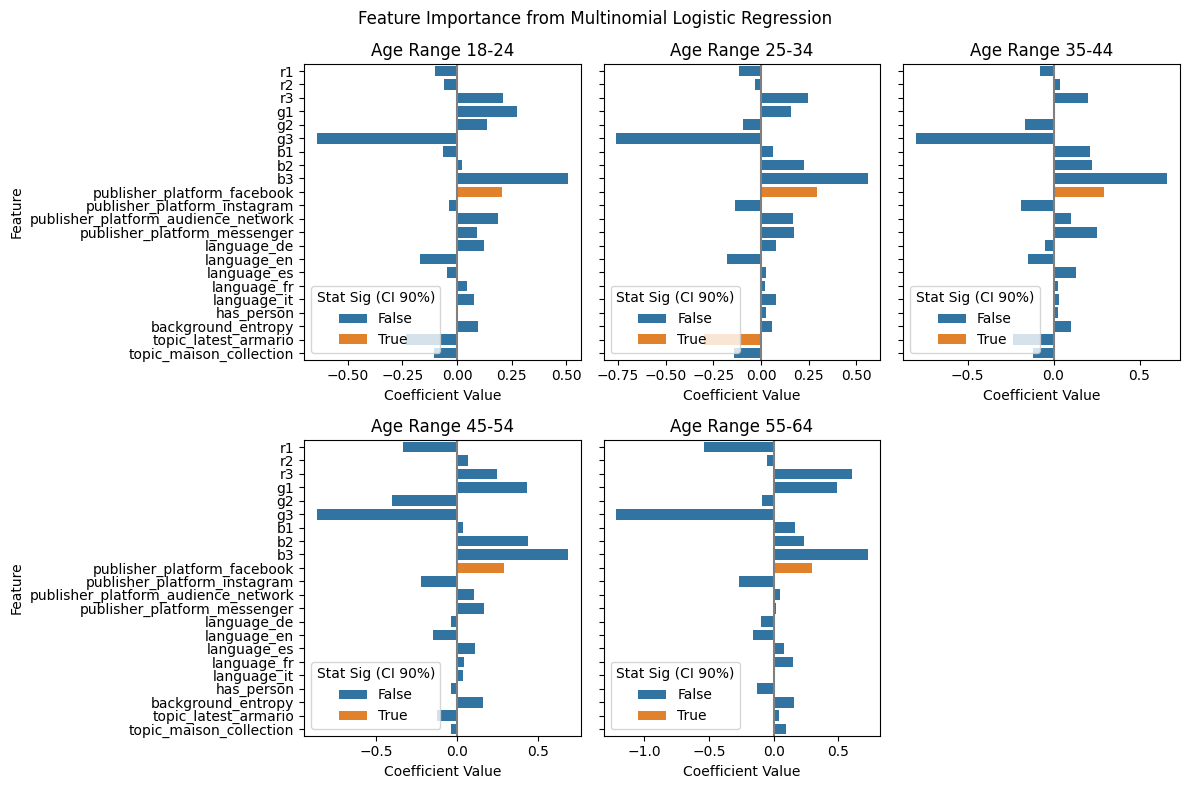

In [1018]:
figure, ax = plt.subplots(2,3, figsize=(12, 8), sharey=True)

for ind , age in enumerate(['18-24', '25-34',  '35-44',   '45-54',  '55-64']):
    i = ind//3
    j = ind %3
    sns.barplot(y = summary_table2_coeff['Feature'], 
                        x= summary_table2_coeff[age], 
                        hue=summary_table2_pvalues[f'{age}_stat_sig_90'],
                         ax=ax[i,j ] )
    ax[i,j ].axvline(x=0, color='grey', linestyle='-')   
    ax[i,j ].set_xlabel('Coefficient Value')
    ax[i,j ].set_title(f'Age Range {age}')
    ax[i,j ].legend(title='Stat Sig (CI 90%)' , loc='lower left')
ax[1,2].axis('off')
    # plt.gca().invert_yaxis()  # highest importance on top
plt.suptitle('Feature Importance from Multinomial Logistic Regression')
plt.tight_layout()
plt.show()

In [1011]:
df_reach6 = df_reach5.merge(X_train[['id'] + publisher_cols])
df_reach6.head()

id     18-24     25-34     35-44     45-54     55-64  \
0  211490241986143  0.079544  0.383959  0.305075  0.208521  0.020918   
1  264553996745105  0.053571  0.547619  0.244048  0.065476  0.047619   
2  277543702118611  0.045074  0.286245  0.305297  0.220725  0.107807   
3  283139521558647  0.032630  0.238004  0.337172  0.286628  0.075496   
4  291076820754070  0.777632  0.212773  0.009584  0.000000  0.000000   

        65+  publisher_platform_facebook  publisher_platform_instagram  \
0  0.001982                            1                             1   
1  0.041667                            1                             1   
2  0.034851                            1                             1   
3  0.030070                            1                             1   
4  0.000011                            0                             1   

   publisher_platform_audience_network  publisher_platform_messenger  
0                                    0                             0  
1                                    1                             1  
2                                    1                             1  
3                                    1                             1  
4                                    0                             0

Text(0.5, 1.0, 'Probability of Reaching an Age Group')

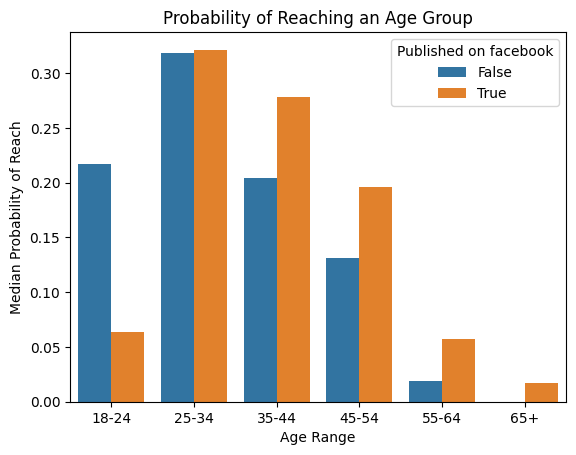

In [755]:
platform = 'facebook'
plot_this = df_reach6.groupby([f"publisher_platform_{platform}"])[age_cols].median().reset_index()\
                .melt(id_vars = f"publisher_platform_{platform}", 
                      value_name='reach_prob',
                      var_name='age_range',
                      value_vars = age_cols)
plot_this[f'publisher_platform_{platform}'] = plot_this[f'publisher_platform_{platform}'].astype(bool)
ax = sns.barplot(data = plot_this,
            x = 'age_range',
            y='reach_prob',
            hue=f'publisher_platform_{platform}')
ax.legend(title = f'Published on {platform}')
plt.xlabel('Age Range')
plt.ylabel('Median Probability of Reach')
plt.title('Probability of Reaching an Age Group')

Text(0.5, 1.0, 'Probability of Reaching an Age Group')

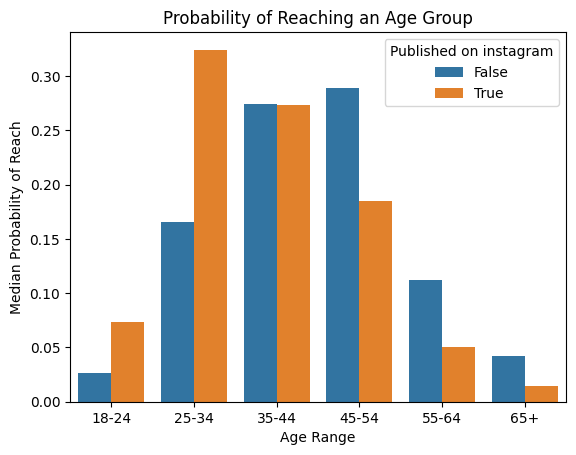

In [756]:
platform = 'instagram'
plot_this = df_reach6.groupby([f"publisher_platform_{platform}"])[age_cols].median().reset_index()\
                .melt(id_vars = f"publisher_platform_{platform}", 
                      value_name='reach_prob',
                      var_name='age_range',
                      value_vars = age_cols)
plot_this[f'publisher_platform_{platform}'] = plot_this[f'publisher_platform_{platform}'].astype(bool)
ax = sns.barplot(data = plot_this,
            x = 'age_range',
            y='reach_prob',
            hue=f'publisher_platform_{platform}')
ax.legend(title = f'Published on {platform}')
plt.xlabel('Age Range')
plt.ylabel('Median Probability of Reach')
plt.title('Probability of Reaching an Age Group')

# 4. Competitive Analysis 

In [768]:
df_active['ad_live_duration'] = (pd.to_datetime(df_active.ad_delivery_stop_time) - pd.to_datetime(df_active.ad_delivery_start_time)).dt.days


### Visualizing Publishing Strategy

In [774]:
df_comp = df_active[['id', 'eu_total_reach', 'page_name','ad_live_duration' ]].groupby('page_name')\
    .agg(eu_total_reach = ('eu_total_reach', 'sum'),
         num_ads = ('id', pd.Series.nunique),
         avg_duration = ('ad_live_duration', 'mean')
         )\
    .sort_values(['eu_total_reach', 'num_ads'], ascending=[0,0])
df_comp.to_csv('../data_clean/competitive_analysis.csv')

In [790]:
X_train.columns

Index(['id', 'ad_delivery_start_year', 'ad_delivery_start_month',
       'eu_total_reach', 'publisher_platform_facebook',
       'publisher_platform_instagram', 'publisher_platform_audience_network',
       'publisher_platform_messenger', 'target_ages_lower',
       'target_ages_upper', 'target_gender_men', 'target_gender_women', 'r1',
       'g1', 'b1', 'r2', 'g2', 'b2', 'r3', 'g3', 'b3', 'has_person',
       'background_entropy', 'has_text', 'language_de', 'language_en',
       'language_es', 'language_fr', 'language_it', 'topic_latest_armario',
       'topic_maison_collection', 'topic_other'],
      dtype='object')

In [773]:
df_comp

avg_eu_reach  num_ads  avg_duration
page_name                                          
H&M            631971.458333       24     53.666667
Burberry       482195.933333       30     19.103448
SAINT LAURENT  375921.500000       14      7.461538
Prada          296853.882353       34     43.640000
Hermès         255309.136364       22     11.045455
Gucci          240138.176000      500      9.937220
Mango          139765.306000      500     28.381643
Louis Vuitton  105097.775316      316     12.143333
CHANEL         104618.444444      441     11.009091
Pull&Bear       65864.627907       43      8.511628
BALENCIAGA      64640.379310       29     17.592593
COS             63132.243619      431     15.346535
Massimo Dutti   62792.564103       39      7.153846
Stradivarius    61598.978166      229      7.885463
Dior            42135.276000      500     13.776087
Bershka         36876.678899      109      8.724771
ZARA            25151.026000      500      5.351626

In [776]:
df_active['ad_delivery_start_time'] = pd.to_datetime(df_active['ad_delivery_start_time'])

In [782]:
df_active.agg( min_date = ('ad_delivery_start_time','min'), 
              max_date=('ad_delivery_start_time',  'max')
              )

ad_delivery_start_time
min_date             2023-10-24
max_date             2025-04-18

In [788]:
df_active.shape

(3761, 21)

In [789]:
df_brand_img.ref_id.nunique()

1171

# 5. Evolution over Time

In [ ]:
### TODO